In [22]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
import joblib
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)

In [23]:
def prepare(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if 'latitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'latitude']
    if 'longitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'longitude']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df.values)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min

    for model in models:
        
        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []

        if n_samples > 0:
            print(f'k = {k}')
            for j in tqdm(range(0, n_samples)):
                if sample_size == -1:
                    sample_size = df.shape[0]   
                sampled_indeces = random.sample(range(df.shape[0]), sample_size)
                sampled_points = [df.iloc[i] for i in sampled_indeces]
                sampled_labels = [model.labels_[i] for i in sampled_indeces]
                silhouettes.append(silhouette_score(sampled_points, sampled_labels))

        silhouettess.append(silhouettes)
        k += 1
    
    scoress_dict = {
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scores_dict, k_min, k_max):
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scores_dict), figsize=(15, 3))

    axes[0].plot(k_values, scores_dict['SSE'][k_min:k_max+1], marker='o')
    axes[0].set_title('SSE')
    axes[0].set_xticks(k_values[::2])
    axes[0].set_xticklabels(k_values[::2])
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('SSE')

    axes[1].plot(k_values, scores_dict['Separation'][k_min:k_max+1], marker='o')
    axes[1].set_title('Separation')
    axes[1].set_xticks(k_values[::2])
    axes[1].set_xticklabels(k_values[::2])
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Separation')

    mean_scores = []
    silhouettess = scores_dict['Silhouette']
    for k in k_values:
        mean_scores.append(np.mean(np.array(silhouettess[k])))
        
    axes[2].plot(k_values, mean_scores, marker='o')
    axes[2].set_title('Silhouette')
    axes[2].set_xticks(k_values[::2])
    axes[2].set_xticklabels(k_values[::2])
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Silhouette')

    plt.tight_layout()
    plt.show()

    return mean_scores

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)


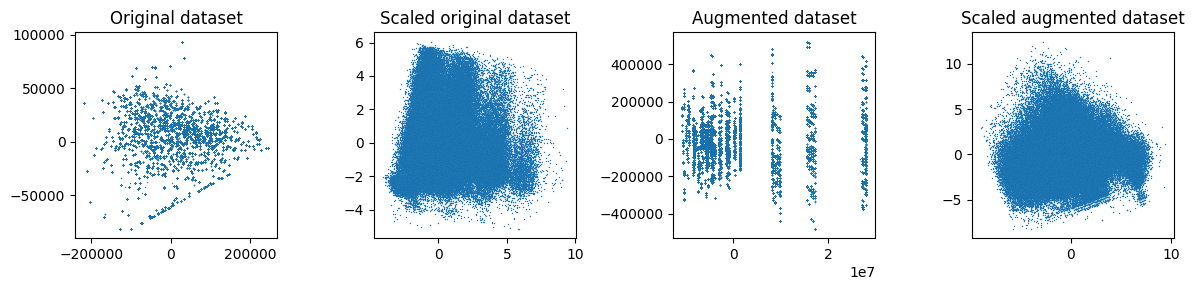

In [99]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df_init, remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df_init, remove_outliers=True, with_indicators=True)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 19

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


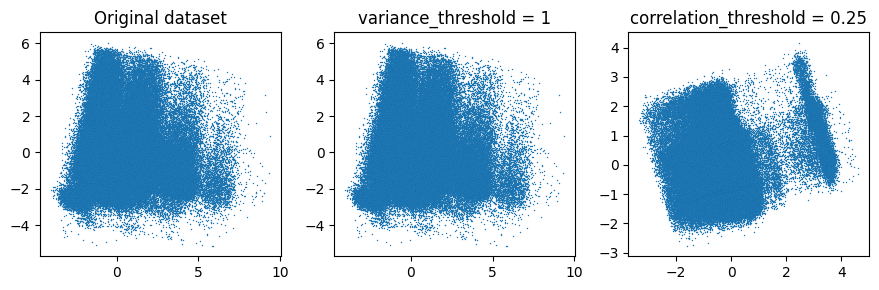

In [25]:
var_thr = 1
reduced_orig_var = features_reduction_var(df_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig_var.columns)}')
print(reduced_orig_var.columns)

corr_thr = 0.25
reduced_orig = features_reduction_corr(reduced_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig.columns)}')
print(reduced_orig.columns)

pca_orig_v = perform_PCA(df=reduced_orig_var, n_components=2)
pca_orig_c = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_orig_v[:, 0], pca_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_orig_c[:, 0], pca_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 51

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_

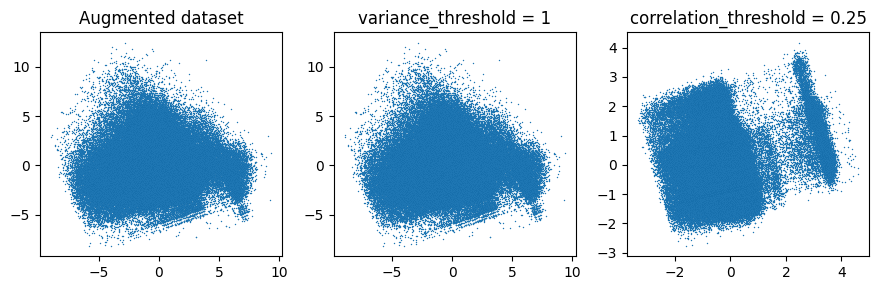

In [26]:
var_thr = 1
reduced_var = features_reduction_var(df_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_var.columns)}')
print(reduced_var.columns)

corr_thr = 0.25
reduced = features_reduction_corr(reduced_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced.columns)}')
print(reduced.columns)

pca_v = perform_PCA(df=reduced_var, n_components=2)
pca_c = perform_PCA(df=reduced, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [27]:
k_min = 2
k_max = 20

models = k_means(df_orig_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:45<00:00,  5.56s/it]


k = 2


 20%|██        | 1/5 [00:00<00:00,  5.69it/s]

100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


k = 3


100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


k = 4


100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


k = 5


100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


k = 6


100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


k = 7


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


k = 8


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


k = 9


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


k = 10


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


k = 11


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


k = 12


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]


k = 13


100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


k = 14


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


k = 15


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


k = 16


100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


k = 17


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


k = 18


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


k = 19


100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


k = 20


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


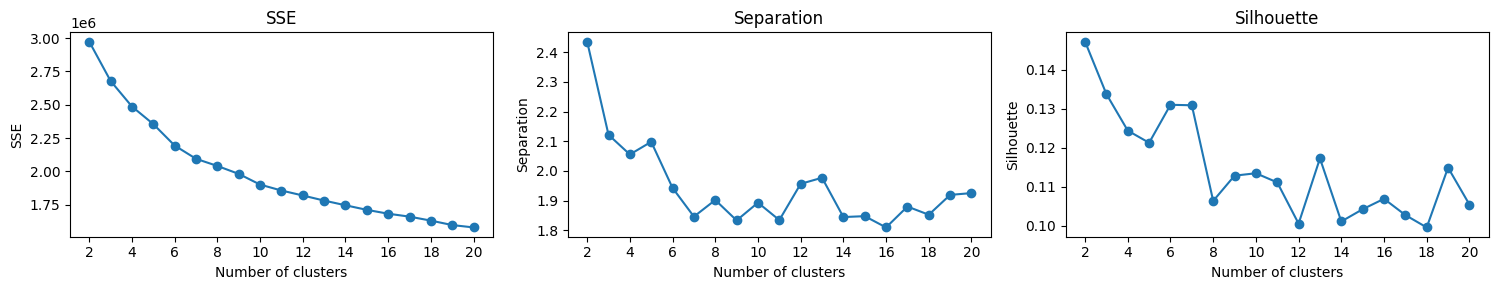

In [28]:
scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=5)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.31s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


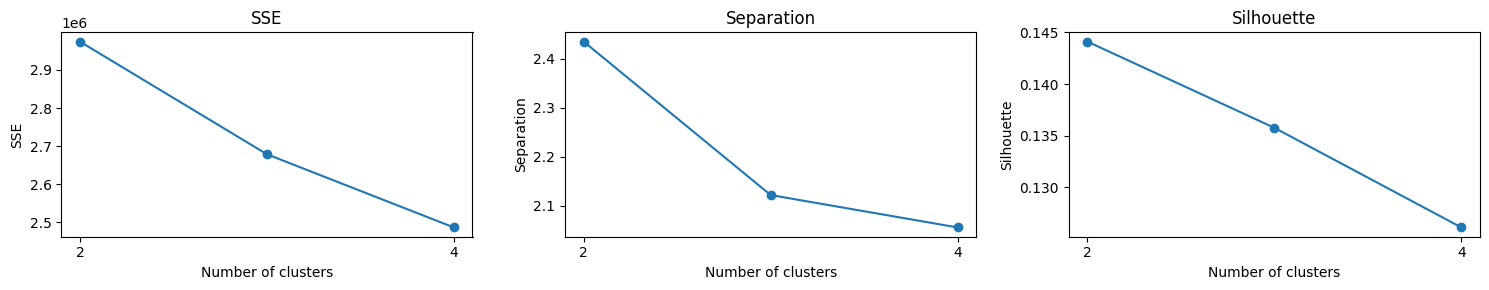


k = 2:
SSE = 2974152.706069432
Separation = 2.435493107149297
Silhouette = 0.1441044736357379

k = 3:
SSE = 2678939.056201356
Separation = 2.121711380561672
Silhouette = 0.13576204190380656

k = 4:
SSE = 2487018.2980562146
Separation = 2.055439400400594
Silhouette = 0.1261188645222516


In [29]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [30]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_orig_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_orig = models[best_k]
joblib.dump(best_model_orig, 'kmeans_orig_ss.pkl')

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:26<00:00,  8.83s/it]


Best mean silhouette score for k = 2:
SSE = 2974152.706069432
Separation = 2.435493107149297
Silhouette = 0.14503449366628177


['kmeans_orig_ss.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


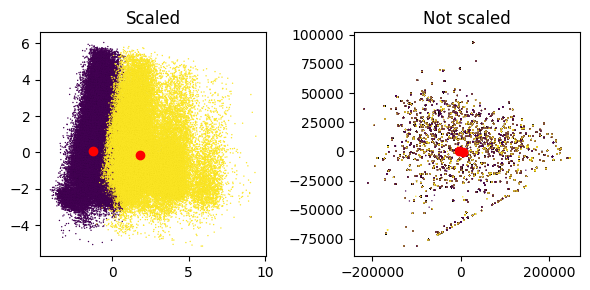

Cluster 0: 112705 points
Cluster 1: 78272 points


In [31]:
labels = best_model_orig.labels_
centroids = best_model_orig.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_orig_s, centroids=centroids, n_components=2)

orig_points = df_orig
orig_centroids = scaler_orig.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced original dataset

In [32]:
k_min = 2
k_max = 20

models = k_means(df=reduced_orig, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:16<00:00,  4.02s/it]


k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


k = 3


100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


k = 4


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


k = 5


100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


k = 6


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


k = 7


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


k = 8


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


k = 9


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


k = 10


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


k = 11


100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


k = 12


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


k = 13


100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


k = 14


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


k = 15


100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


k = 16


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


k = 17


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


k = 18


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


k = 19


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


k = 20


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


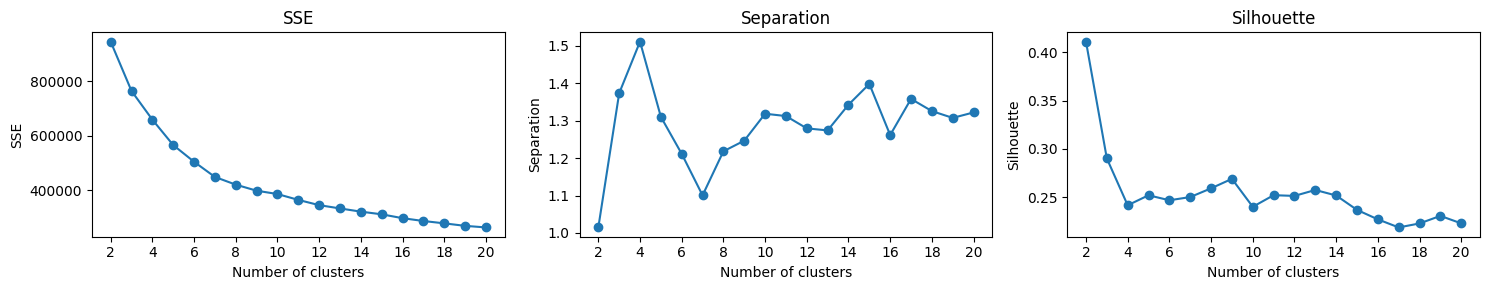

In [33]:
scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=5)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


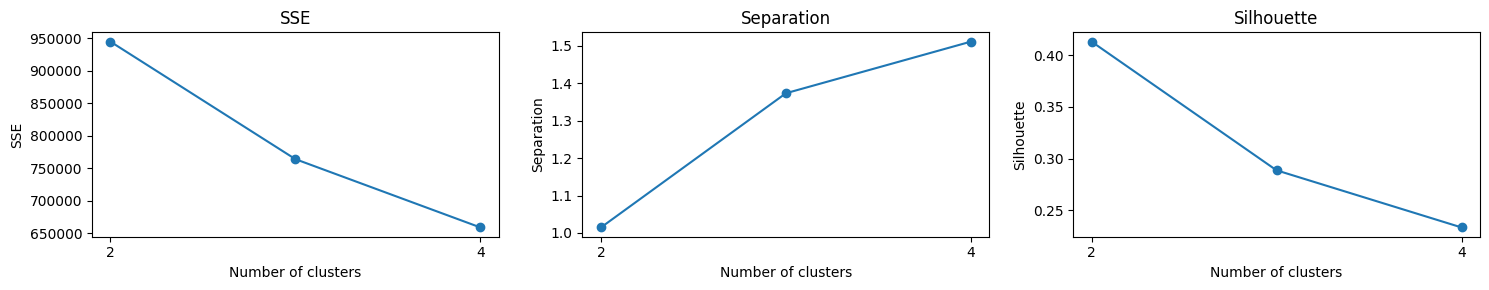


k = 2:
SSE = 944734.0845960034
Separation = 1.014701571838864
Silhouette = 0.4131590495758893

k = 3:
SSE = 764004.6328146383
Separation = 1.3732157355973449
Silhouette = 0.2886255486552822

k = 4:
SSE = 658969.9006858062
Separation = 1.511066653936986
Silhouette = 0.23334067012692028


In [34]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [35]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_orig, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_r_orig = models[best_k]
joblib.dump(best_model_r_orig, 'kmeans_r_orig_ss.pkl')

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.94s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960034
Separation = 1.014701571838864
Silhouette = 0.4136903924004927


['kmeans_r_orig_ss.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


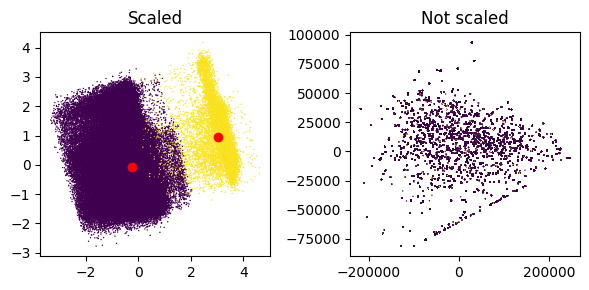

Cluster 0: 177714 points
Cluster 1: 13263 points


In [36]:
labels = best_model_r_orig.labels_
centroids = best_model_r_orig.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_orig, centroids=centroids, n_components=2)

orig_points = df_orig

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [37]:
k_min = 2
k_max = 20

models = k_means(df=df_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [02:52<00:00,  9.10s/it]


k = 2


100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


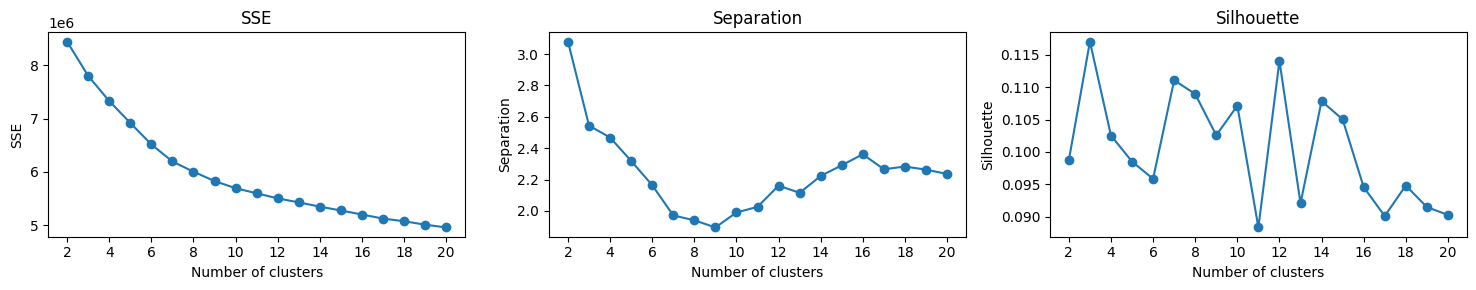

In [38]:
scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


k = 5


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


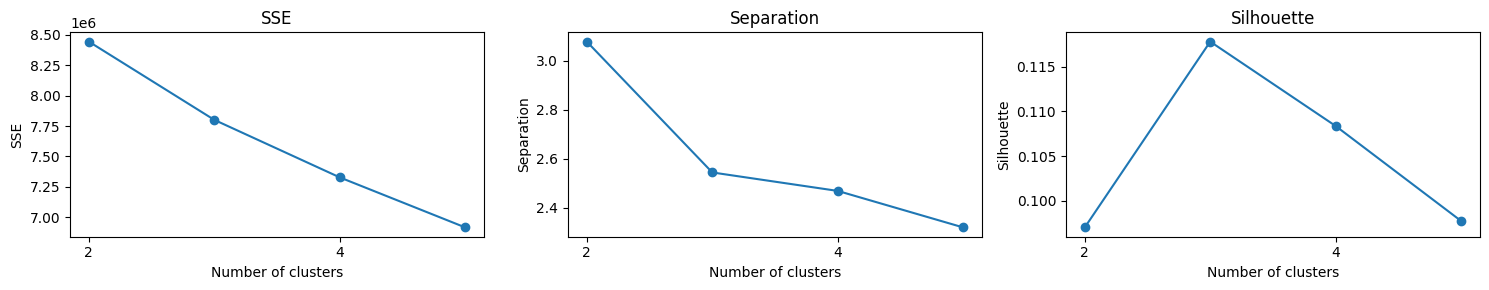


k = 2:
SSE = 8443180.112183124
Separation = 3.0792914917877283
Silhouette = 0.097013355825997

k = 3:
SSE = 7800452.148170631
Separation = 2.543548805111364
Silhouette = 0.11781627182023517

k = 4:
SSE = 7328047.275755709
Separation = 2.4679045223356884
Silhouette = 0.10836567342637571

k = 5:
SSE = 6917170.794384721
Separation = 2.3183774694008994
Silhouette = 0.09773003675146014


In [39]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [40]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model = models[best_k]
joblib.dump(best_model, 'kmeans_ss.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.88s/it]


Best mean silhouette score for k = 3:
SSE = 7800452.148170631
Separation = 2.543548805111364
Silhouette = 0.11511717733052189


['kmeans_ss.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


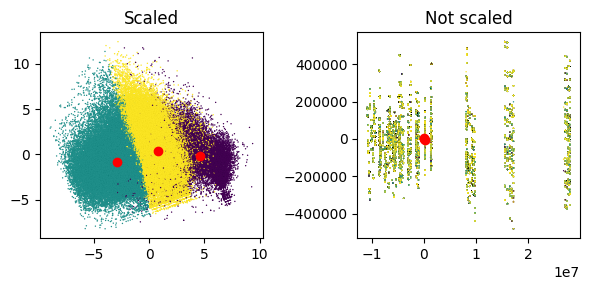

Cluster 0: 12887 points
Cluster 1: 53577 points
Cluster 2: 124513 points


In [41]:
labels = best_model.labels_
centroids = best_model.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_s, centroids=centroids, n_components=2)

orig_points = df
orig_centroids = scaler.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced augmented dataset
(the same as with the reduced original dataset)

In [42]:
k_min = 2
k_max = 20

models = k_means(df=reduced, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:11<00:00,  3.76s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


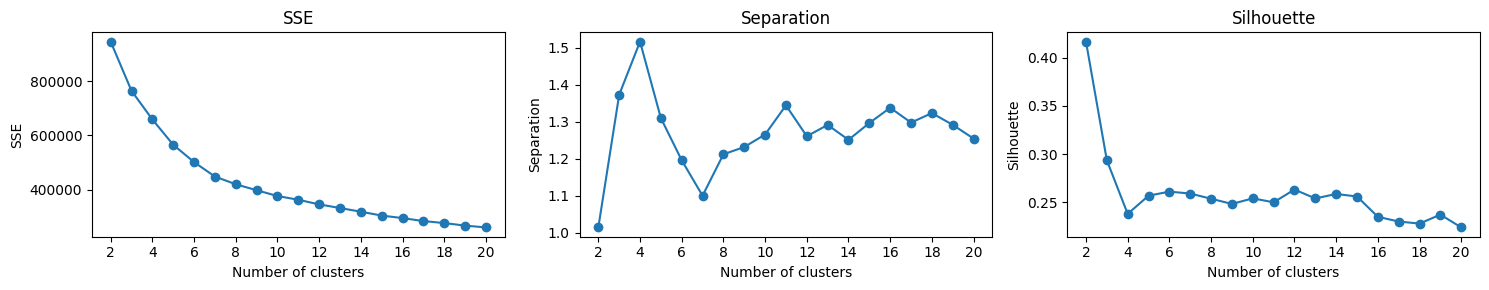

In [43]:
scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


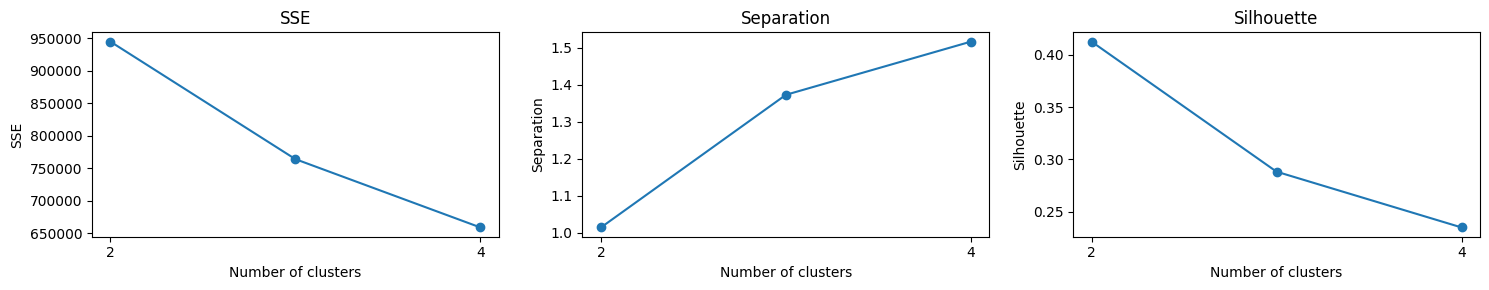


k = 2:
SSE = 944734.0845960035
Separation = 1.014701571838864
Silhouette = 0.41255563933122397

k = 3:
SSE = 764004.6328146383
Separation = 1.3732157355973447
Silhouette = 0.2882749648464995

k = 4:
SSE = 658959.4934320054
Separation = 1.5169414775829106
Silhouette = 0.23499316402069229


In [44]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [45]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_r = models[best_k]
joblib.dump(best_model_r, 'kmeans_r_ss.pkl')

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.97s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960035
Separation = 1.014701571838864
Silhouette = 0.4128282000445678


['kmeans_r_ss.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


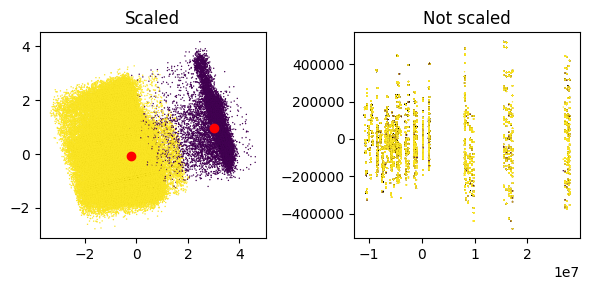

Cluster 0: 13263 points
Cluster 1: 177714 points


In [46]:
labels = best_model_r.labels_
centroids = best_model_r.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced, centroids=centroids, n_components=2)

orig_points = df

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### + Trying with only indicators

Idicator dataset dimentions: (190977, 21)


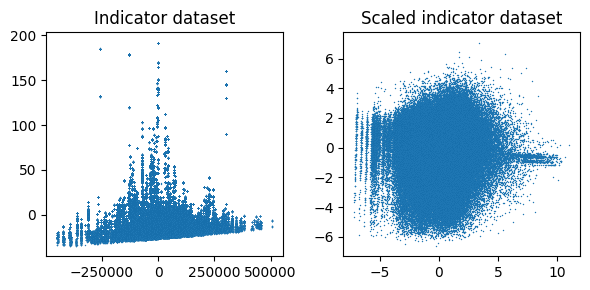

In [100]:
df_ind = df[['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER']]

scaler_ind = StandardScaler()
df_ind_s = scaler_ind.fit_transform(df_ind)
df_ind_s = pd.DataFrame(df_ind_s, columns=df_ind.columns)

print(f'Idicator dataset dimentions: {df_ind.shape}')

pca = perform_PCA(df=df_ind, n_components=2)
pca_s = perform_PCA(df=df_ind_s, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Indicator dataset')

plt.subplot(1, 2, 2)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled indicator dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 21

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 21
Index(['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['month_cd_change_min_age_participants', 'month_cd_ratio_males',
       'month_

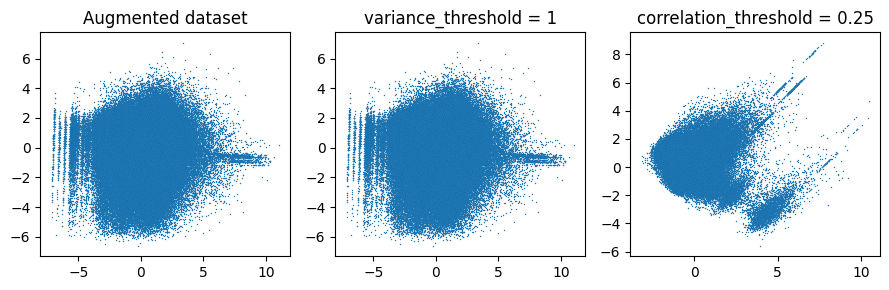

In [48]:
var_thr = 1
reduced_ind_var = features_reduction_var(df_ind_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_ind_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind_var.columns)}')
print(reduced_ind_var.columns)

corr_thr = 0.25
reduced_ind = features_reduction_corr(reduced_ind_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind.columns)}')
print(reduced_ind.columns)

pca_v = perform_PCA(df=reduced_ind_var, n_components=2)
pca_c = perform_PCA(df=reduced_ind, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### K-means on the full indicator dataset

In [49]:
k_min = 2
k_max = 20

models = k_means(df=df_ind_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:46<00:00,  5.58s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


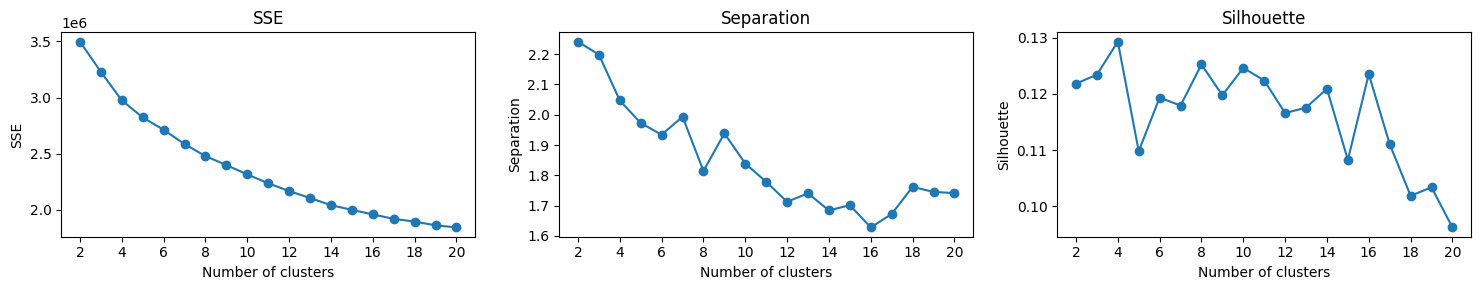

In [50]:
scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


k = 5


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


k = 6


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


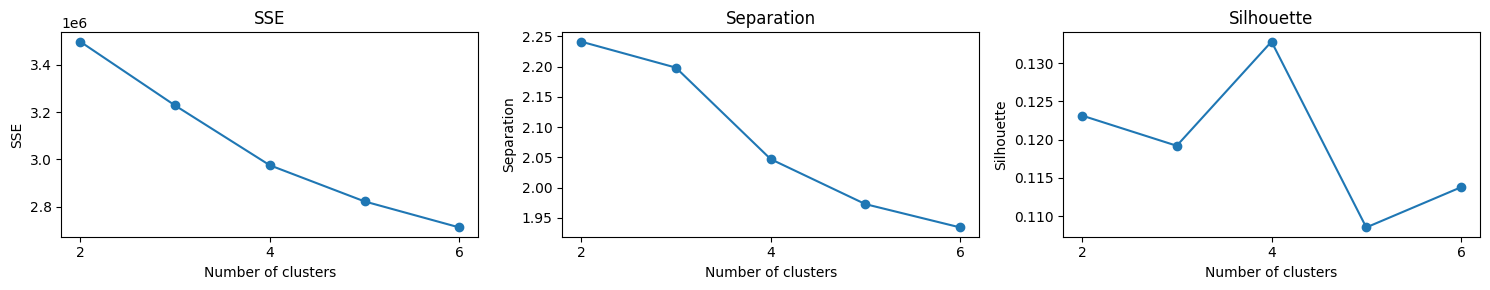


k = 2:
SSE = 3497747.8557476434
Separation = 2.241497127563823
Silhouette = 0.12314618945643434

k = 3:
SSE = 3228192.8115931177
Separation = 2.198486044946801
Silhouette = 0.11920452811122602

k = 4:
SSE = 2975477.8984040422
Separation = 2.0472099681954354
Silhouette = 0.13278969149706235

k = 5:
SSE = 2822671.481690572
Separation = 1.9727218151276886
Silhouette = 0.10855111781474192

k = 6:
SSE = 2712731.968199706
Separation = 1.934182689410872
Silhouette = 0.11379562739571025


In [51]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [52]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_ind_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_ind = models[best_k]
joblib.dump(best_model_ind, 'kmeans_ind_ss.pkl')

k = 4


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.70s/it]


Best mean silhouette score for k = 4:
SSE = 2975477.8984040422
Separation = 2.0472099681954354
Silhouette = 0.13247746209085098


['kmeans_ind_ss.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


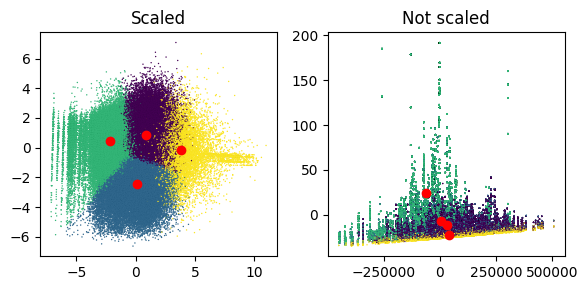

Cluster 0: 80614 points
Cluster 1: 39364 points
Cluster 2: 58304 points
Cluster 3: 12695 points


In [53]:
labels = best_model_ind.labels_
centroids = best_model_ind.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_ind_s, centroids=centroids, n_components=2)

orig_points = df_ind
orig_centroids = scaler_ind.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced indicator dataset

In [54]:
k_min = 2
k_max = 20

models = k_means(df=reduced_ind, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:20<00:00,  4.26s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


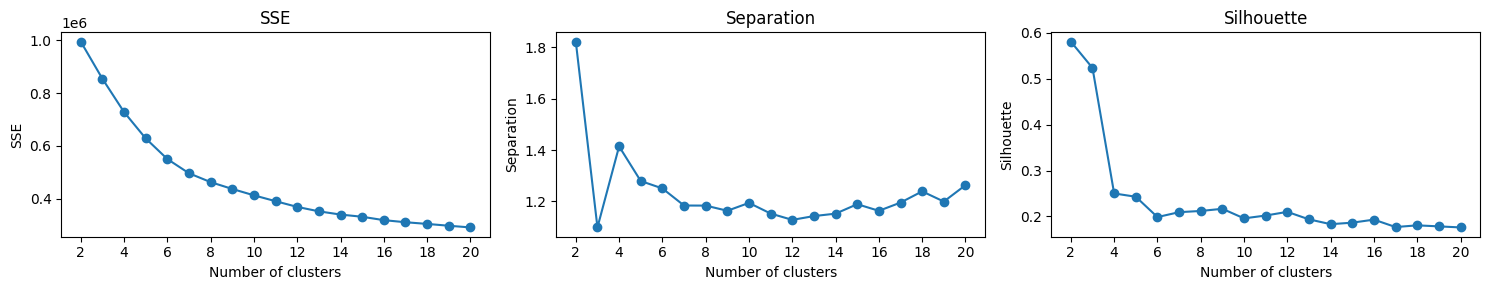

In [55]:
scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


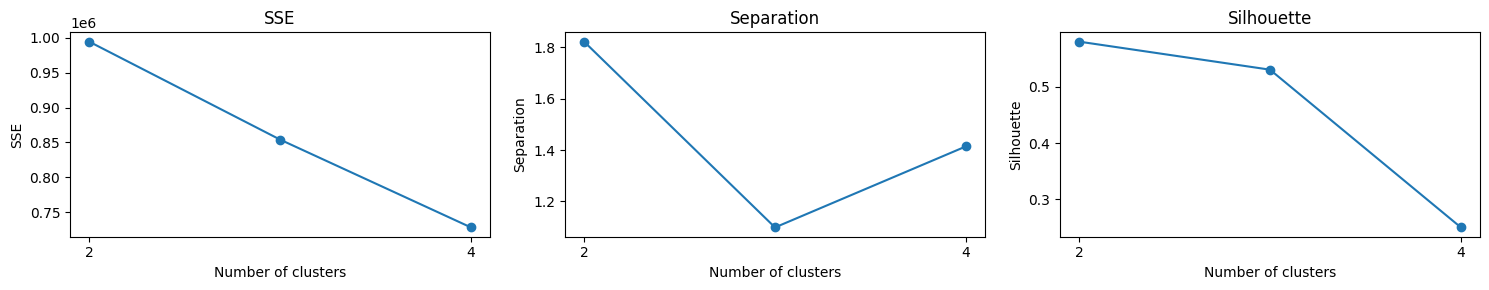


k = 2:
SSE = 994469.005035937
Separation = 1.8221097850015722
Silhouette = 0.5798485336830824

k = 3:
SSE = 854059.418999624
Separation = 1.0985791078817269
Silhouette = 0.5300878235031216

k = 4:
SSE = 728154.1614215376
Separation = 1.4141569499734308
Silhouette = 0.2502160498166477


In [56]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [57]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_ind, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_r_ind = models[best_k]
joblib.dump(best_model_r_ind, 'kmeans_r_ind_ss.pkl')

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.69s/it]


Best mean silhouette score for k = 2:
SSE = 994469.005035937
Separation = 1.8221097850015722
Silhouette = 0.5789419770798929


['kmeans_r_ind_ss.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


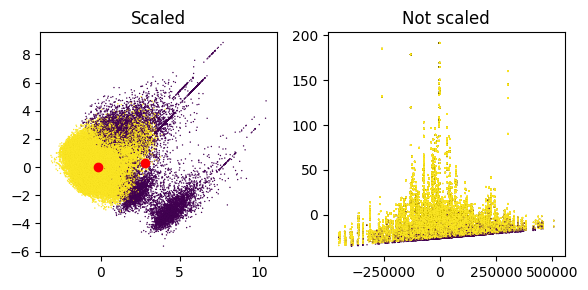

Cluster 0: 11560 points
Cluster 1: 179417 points


In [58]:
labels = best_model_r_ind.labels_
centroids = best_model_r_ind.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_ind, centroids=centroids, n_components=2)

orig_points = df_ind

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

## Analysis

#### Original data clustering

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


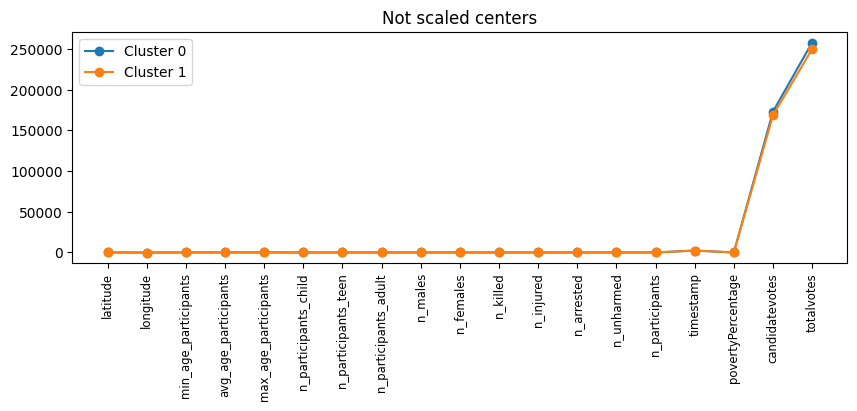

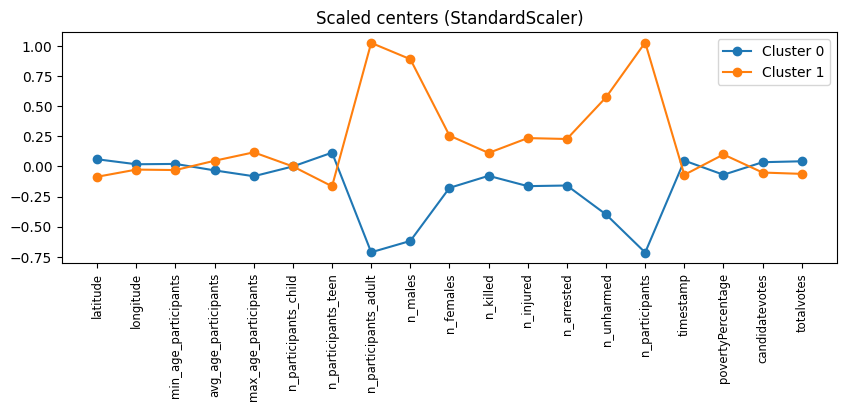

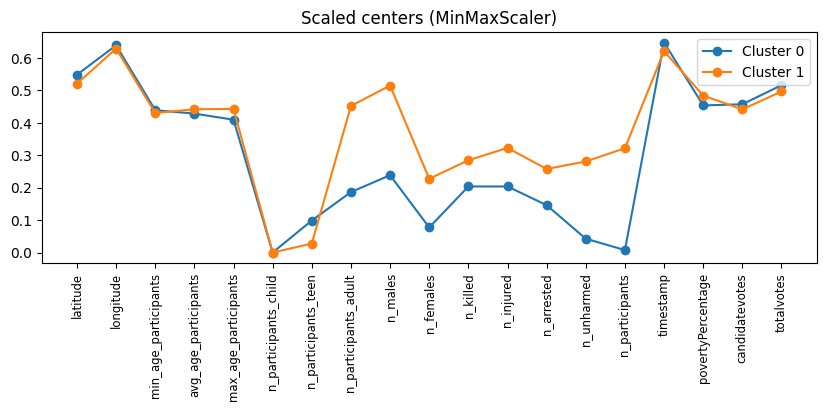

In [59]:
centers_s = best_model_orig.cluster_centers_
cols = df_orig.columns

#mean = np.mean(df_orig.values, axis=0)
#std_dev = np.std(df_orig.values, axis=0)
#centers = [c*std_dev + mean for c in centers_s]

centers = scaler_orig.inverse_transform(centers_s)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df_orig)
centers_s2 = minmaxscaler.transform(centers)

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Not scaled centers')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Scaled centers (StandardScaler)')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s2[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.title('Scaled centers (MinMaxScaler)')
plt.legend()
plt.show()

In [60]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

df_c =  df_init[df_init['OUTLIER'] == 0]
df_c = df_c[cat_cols]

In [61]:
party_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         65928       46777
1         43586       34686

In [62]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.584961    0.415039
1  0.556853    0.443147

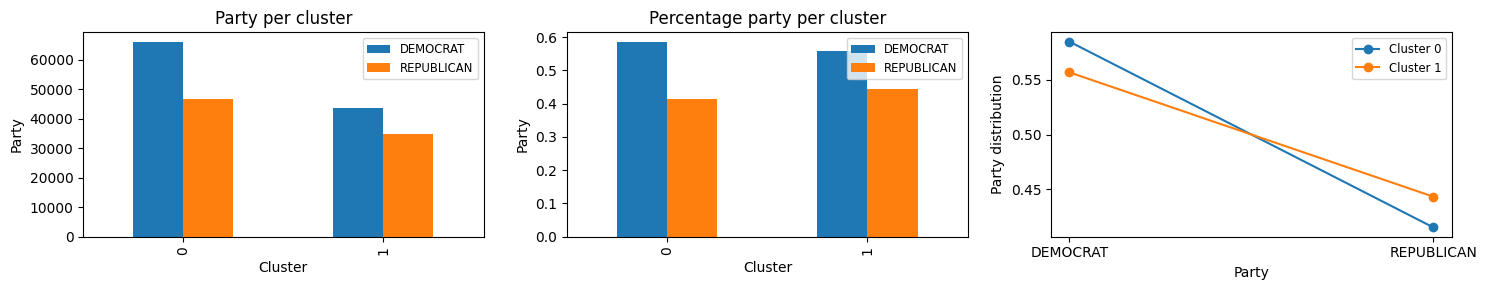

In [63]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [64]:
day_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         4215  3604  3572  3643  3759  3670  3676  3608  3606  3495  ...   
1         2745  2426  2561  2573  2592  2559  2495  2581  2461  2517  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         3530  3716  3518  3818  3718  3784  3811  3519  3490  2203  
1         2551  2520  2538  2657  2635  2603  2512  2424  2316  1613  

[2 rows x 31 columns]

In [65]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.037399  0.031977  0.031693  0.032323  0.033353  0.032563  0.032616   
1  0.035070  0.030994  0.032719  0.032873  0.033115  0.032694  0.031876   

         8         9         10  ...        22        23        24        25  \
0  0.032013  0.031995  0.031010  ...  0.031321  0.032971  0.031214  0.033876   
1  0.032975  0.031442  0.032157  ...  0.032591  0.032195  0.032425  0.033946   

         26        27        28        29        30        31  
0  0.032989  0.033574  0.033814  0.031223  0.030966  0.019547  
1  0.033665  0.033256  0.032093  0.030969  0.029589  0.020608  

[2 rows x 31 columns]

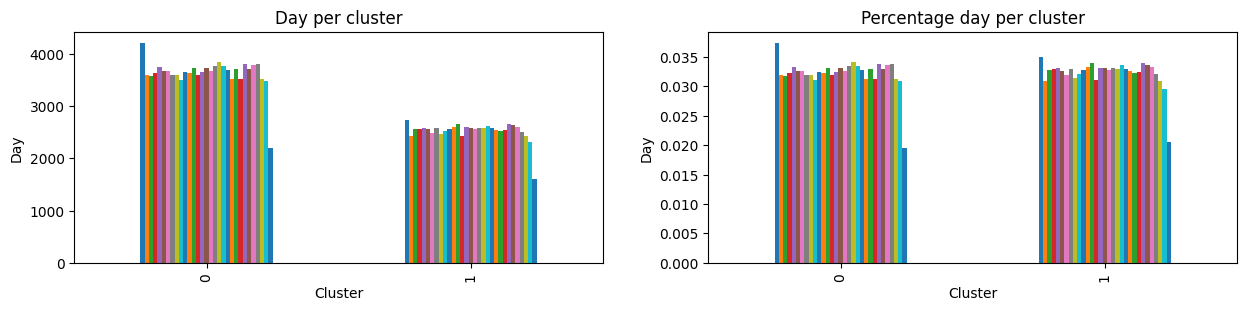

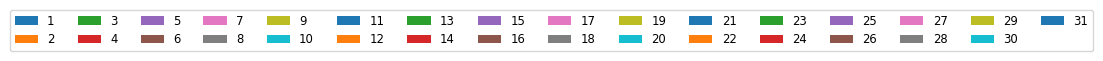

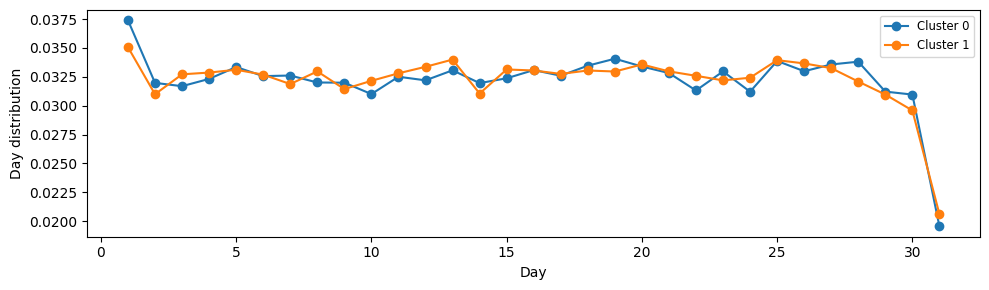

In [66]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [67]:
month_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1     2      3     4     5     6     7     8     9     10  \
row_0                                                                      
0           10877  9110  10915  8618  9104  8529  9704  9827  9049  9314   
1            7633  6133   7360  5922  6496  6035  6747  6852  6359  6504   

date_month    11    12  
row_0                   
0           8422  9236  
1           5951  6280

In [68]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096509  0.080830  0.096846  0.076465  0.080777  0.075675  0.086101   
1  0.097519  0.078355  0.094031  0.075659  0.082993  0.077103  0.086199   

         8         9         10        11        12  
0  0.087192  0.080289  0.082641  0.074726  0.081948  
1  0.087541  0.081242  0.083095  0.076030  0.080233

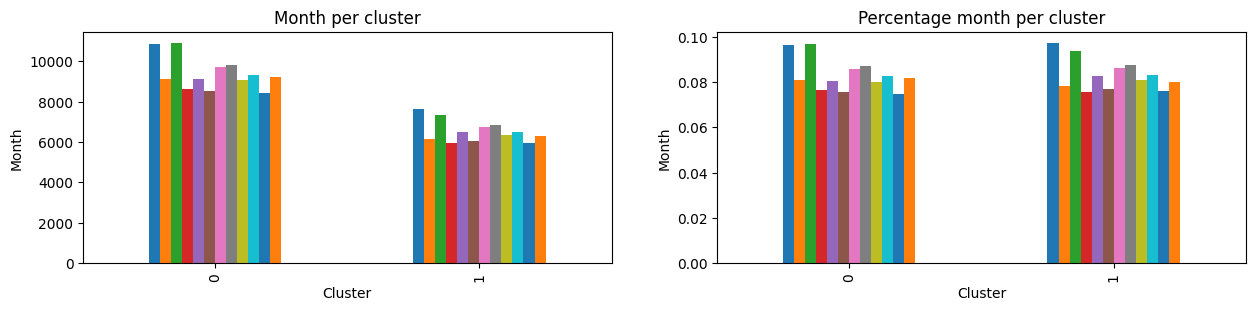

In [69]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [70]:
year_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              17   16993   22921   31160   34039    7575
1              24   14799   16501   21531   20893    4524

In [71]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000151  0.150774  0.203372  0.276474  0.302019  0.067211
1  0.000307  0.189071  0.210816  0.275079  0.266928  0.057798

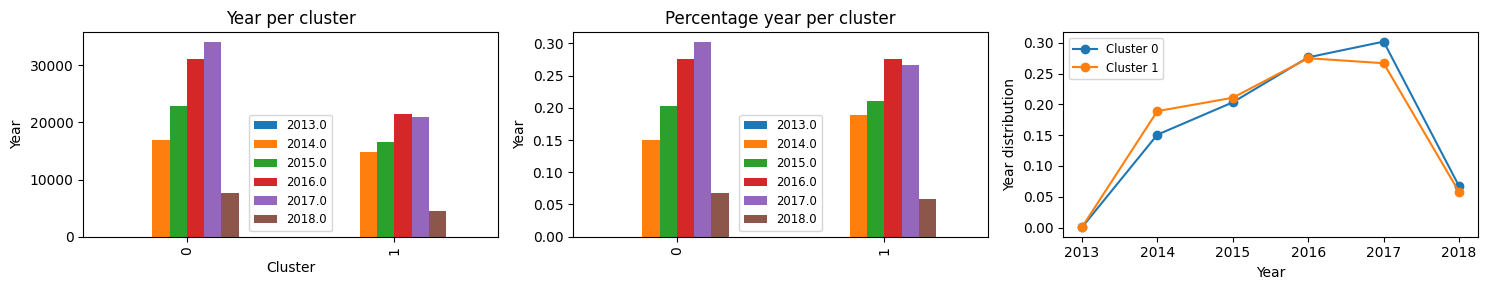

In [72]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [73]:
state_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         2333      92     1081      1298        6486      1778         1842   
1         2004      65      829      1114        3804      1087          933   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1031     6384     3887  ...           312       3536   4672   473   
1           404     4845     3369  ...           178       2612   4858   379   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          230      2981        1606            777       2674      266  
1          155      1869        1217            548       1519      185  

[2 rows x 50 columns]

In [74]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.020700  0.000816  0.009591  0.011517    0.057548  0.015776     0.016344   
1  0.025603  0.000830  0.010591  0.014232    0.048600  0.013887     0.011920   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.009148  0.056643  0.034488  ...      0.002768   0.031374  0.041453   
1  0.005161  0.061900  0.043042  ...      0.002274   0.033371  0.062066   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004197  0.002041  0.026450    0.014250       0.006894   0.023726   
1  0.004842  0.001980  0.023878    0.015548       0.007001   0.019407   

    WYOMING  
0  0.002360  
1  0.002364  

[2 rows x 50 columns]

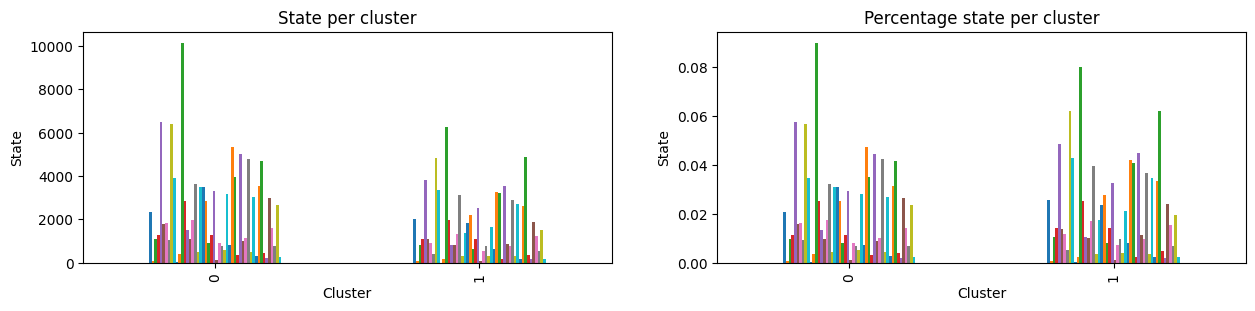

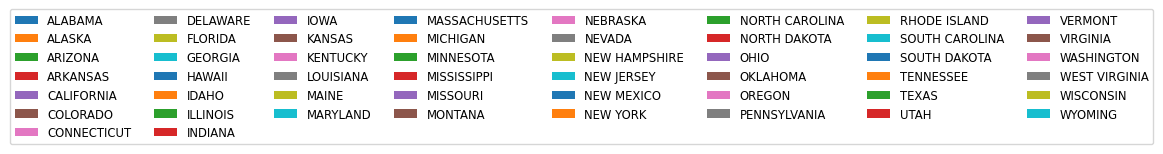

In [75]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [76]:
ic_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   2811                  255   
1                                   3060                   84   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 3                 13   
1                                                 1                  8   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   37                            17   
1                                  221                            11   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     11                 52        38   
1                                     25                140        24   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       551  ...                 147   
1                                       294  ...                  92   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     1               2         404       29   
1                                     3               1         256        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       62        1170                4   
1                                        9         828                1   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                     861                       0  
1                                     274                       1  

[2 rows x 49 columns]

In [77]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.024941             0.002263                  0.000027   
1       0.039094             0.001073                  0.000013   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000115     0.000328                      0.000151   
1           0.000102     0.002823                      0.000141   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000098           0.000461  0.000337          0.004889  ...   
1       0.000319           0.001789  0.000307          0.003756  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001304      0.000009        0.000018    0.003585  0.000257   
1            0.001175      0.000038        0.000013    0.003271  0.000013   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000550    0.010381         0.000035        0.007639   
1         0.000115    0.010578         0.000013        0.003501   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000013  

[2 rows x 49 columns]

In [78]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced original data clustring

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


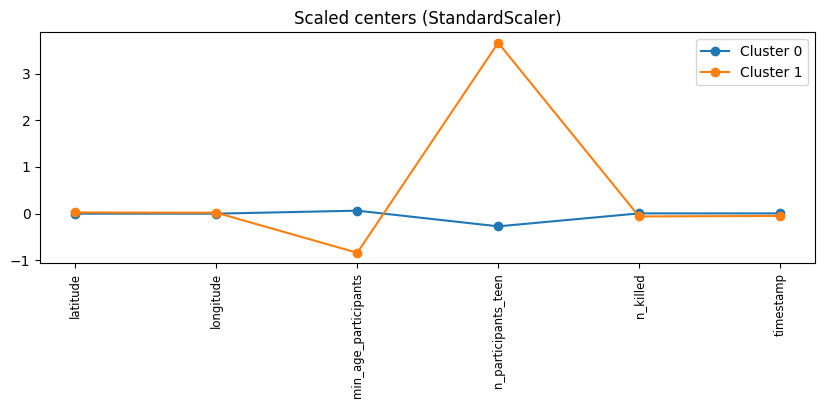

In [79]:
centers_s = best_model_r_orig.cluster_centers_
cols = reduced_orig.columns

mean = np.mean(df_orig[cols].values, axis=0)
std_dev = np.std(df_orig[cols].values, axis=0)
centers = [c*std_dev + mean for c in centers_s]

#centers = scaler_orig.inverse_transform(centers_s)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df_orig[cols])
centers_s2 = minmaxscaler.transform(centers)

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Not scaled centers')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Scaled centers (StandardScaler)')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s2[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.title('Scaled centers (MinMaxScaler)')
plt.legend()
plt.show()

In [80]:
party_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0        101585       76129
1          7929        5334

In [81]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.571621    0.428379
1  0.597829    0.402171

In [82]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [83]:
day_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         6472  5605  5730  5807  5894  5777  5750  5761  5616  5606  ...   
1          488   425   403   409   457   452   421   428   451   406  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         5683  5803  5632  6041  5928  5961  5889  5527  5406  3577  
1          398   433   424   434   425   426   434   416   400   239  

[2 rows x 31 columns]

In [84]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036418  0.031539  0.032243  0.032676  0.033166  0.032507  0.032355   
1  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   

         8         9         10  ...        22        23        24        25  \
0  0.032417  0.031601  0.031545  ...  0.031978  0.032654  0.031691  0.033993   
1  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   

         26        27        28        29        30        31  
0  0.033357  0.033543  0.033138  0.031101  0.030420  0.020128  
1  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  

[2 rows x 31 columns]

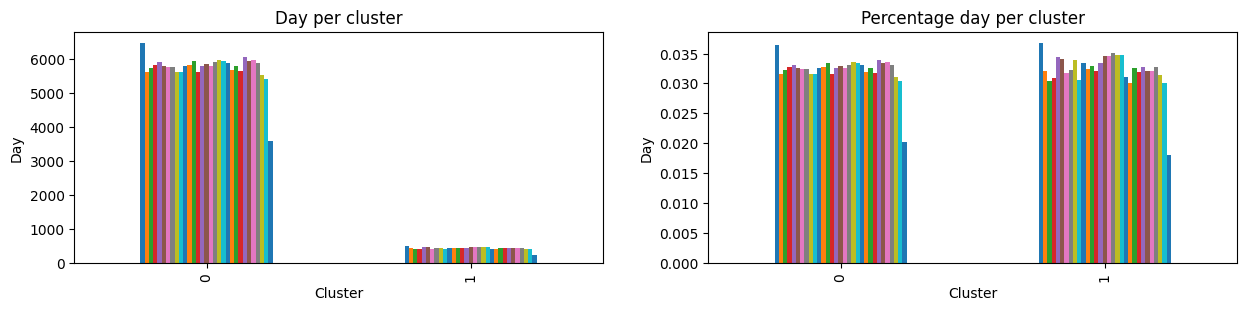

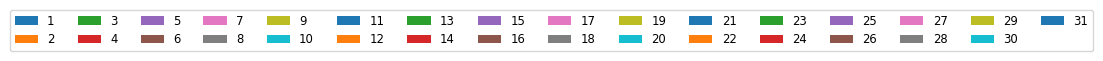

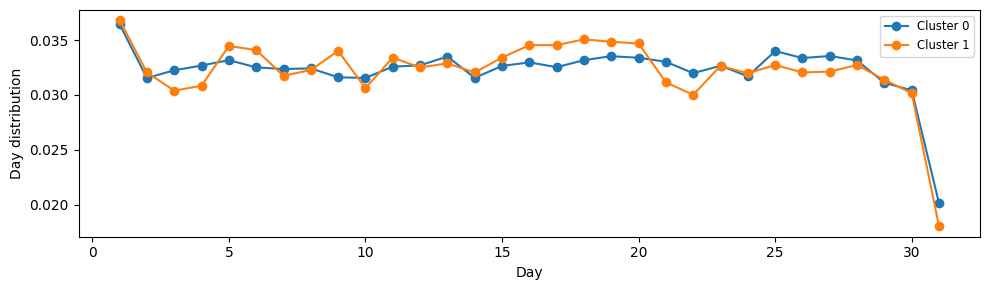

In [85]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [86]:
month_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           17223  14142  17026  13514  14487  13564  15324  15545  14350   
1            1287   1101   1249   1026   1113   1000   1127   1134   1058   

date_month     10     11     12  
row_0                            
0           14726  13334  14479  
1            1092   1039   1037

In [87]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096914  0.079577  0.095806  0.076044  0.081519  0.076325  0.086228   
1  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   

         8         9         10        11        12  
0  0.087472  0.080748  0.082863  0.075031  0.081474  
1  0.085501  0.079771  0.082334  0.078338  0.078187

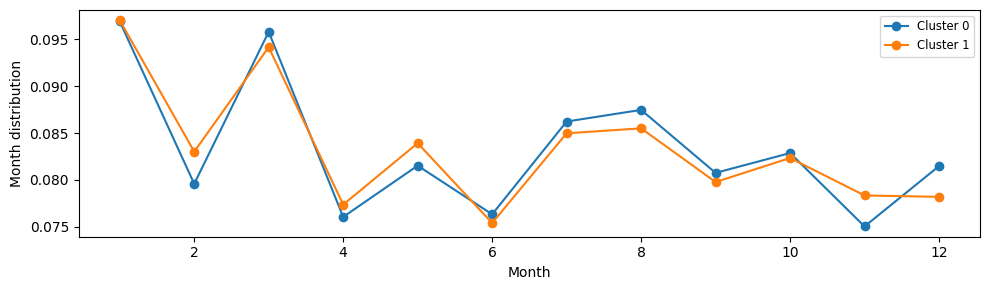

In [88]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [89]:
year_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              39   29342   36553   49283   51235   11262
1               2    2450    2869    3408    3697     837

In [90]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000219  0.165108  0.205684  0.277316  0.288300  0.063371
1  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108

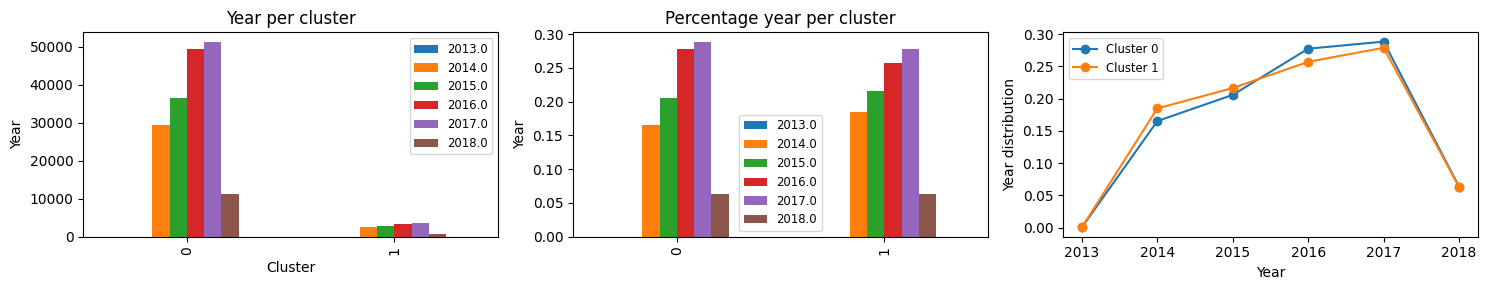

In [91]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [92]:
state_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         4081     152     1796      2239        9649      2692         2629   
1          256       5      114       173         641       173          146   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1302    10409     6742  ...           457       5651   8909   789   
1           133      820      514  ...            33        497    621    63   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          374      4436        2629           1272       3886      431  
1           11       414         194             53        307       20  

[2 rows x 50 columns]

In [93]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.022964  0.000855  0.010106  0.012599    0.054295  0.015148     0.014793   
1  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007326  0.058572  0.037937  ...      0.002572   0.031798  0.050131   
1  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   

      UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN   WYOMING  
0  0.00444  0.002105  0.024961    0.014793       0.007158   0.021867  0.002425  
1  0.00475  0.000829  0.031215    0.014627       0.003996   0.023147  0.001508  

[2 rows x 50 columns]

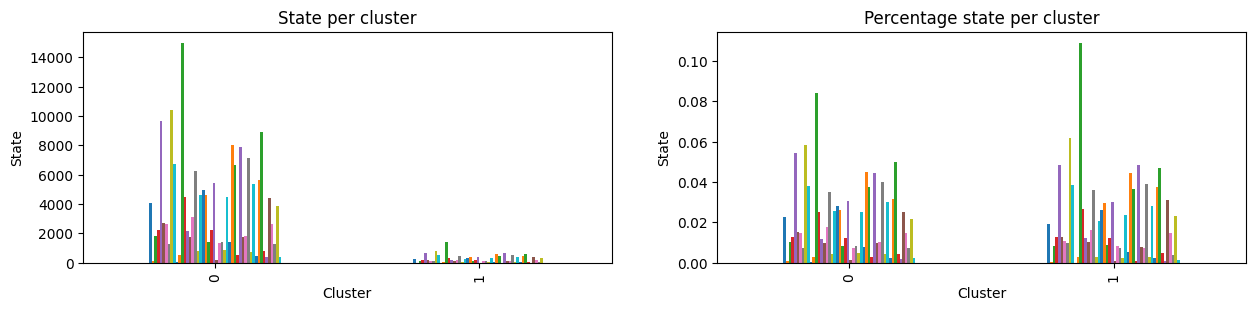

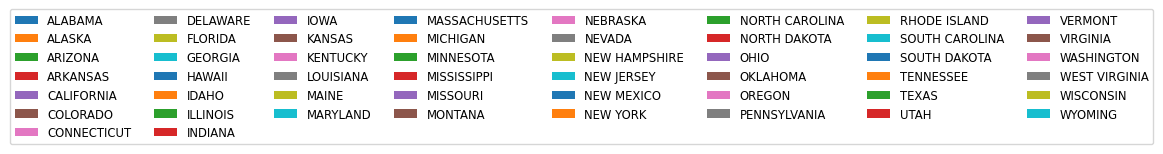

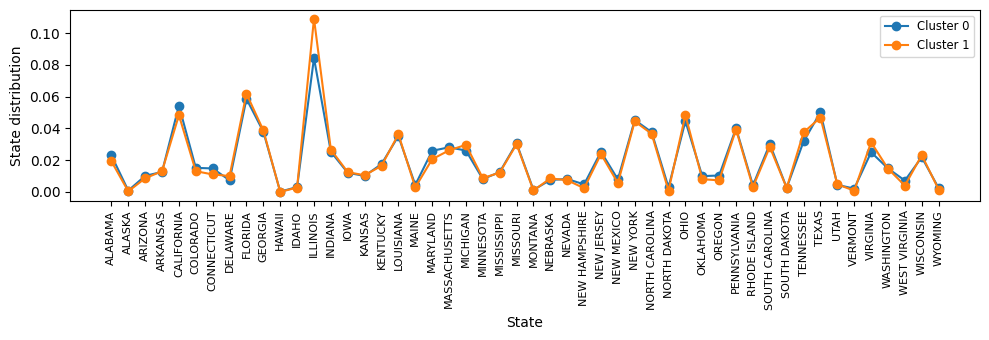

In [94]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [95]:
ic_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5697                  319   
1                                    174                   20   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 19   
1                                                 0                  2   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  240                            28   
1                                   18                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     34                184        57   
1                                      2                  8         5   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       820  ...                 230   
1                                        25  ...                   9   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               3         611       29   
1                                     0               0          49        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       68        1866                5   
1                                        3         132                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1067                       1  
1                                      68                       0  

[2 rows x 49 columns]

In [96]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.032057             0.001795                  0.000023   
1       0.013119             0.001508                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000107     0.001350                      0.000158   
1           0.000151     0.001357                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000191           0.001035  0.000321          0.004614  ...   
1       0.000151           0.000603  0.000377          0.001885  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001294      0.000023        0.000017    0.003438  0.000163   
1            0.000679      0.000000        0.000000    0.003694  0.000075   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000383    0.010500         0.000028        0.006004   
1         0.000226    0.009952         0.000000        0.005127   

   UNLAWFUL_PURCHASE_SALE  
0                0.000006  
1                0.000000  

[2 rows x 49 columns]

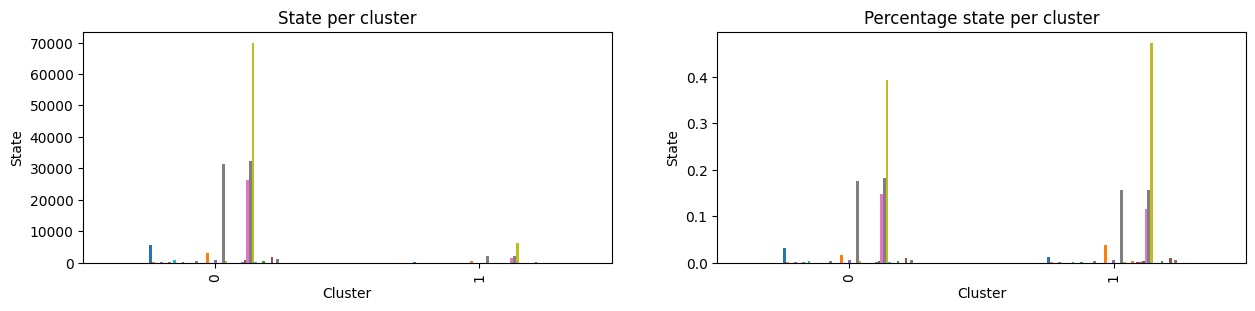

In [97]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Augmented data clustering

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


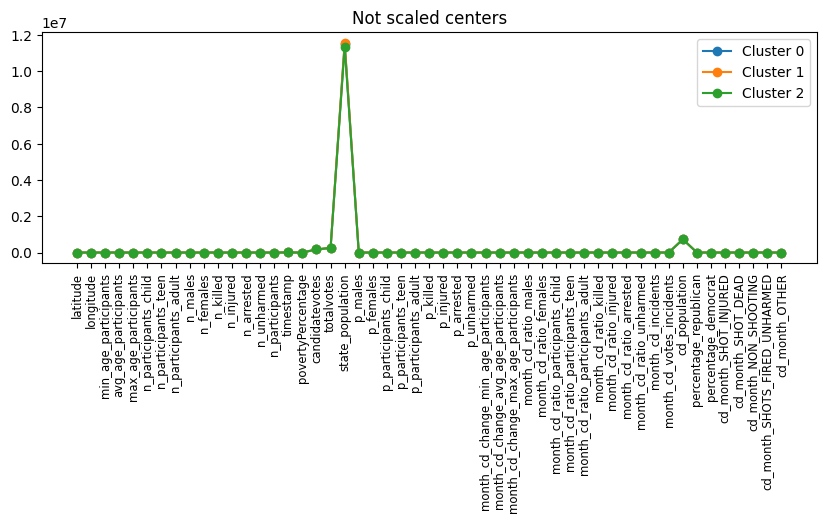

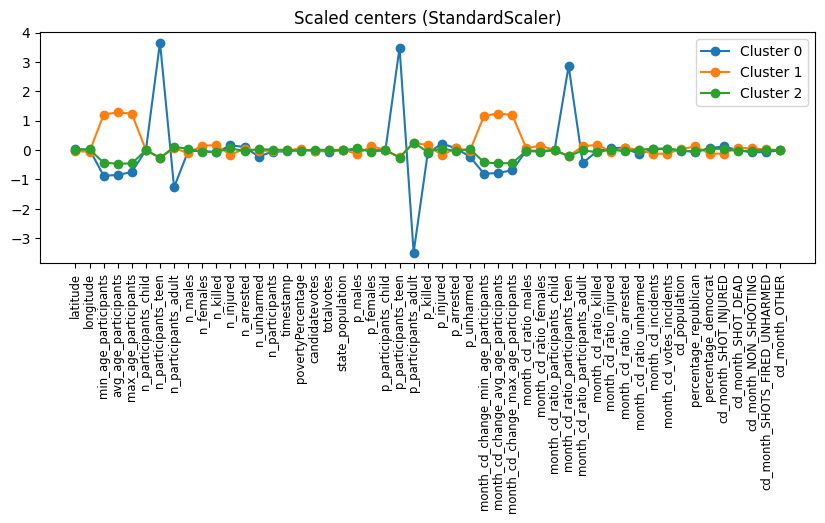

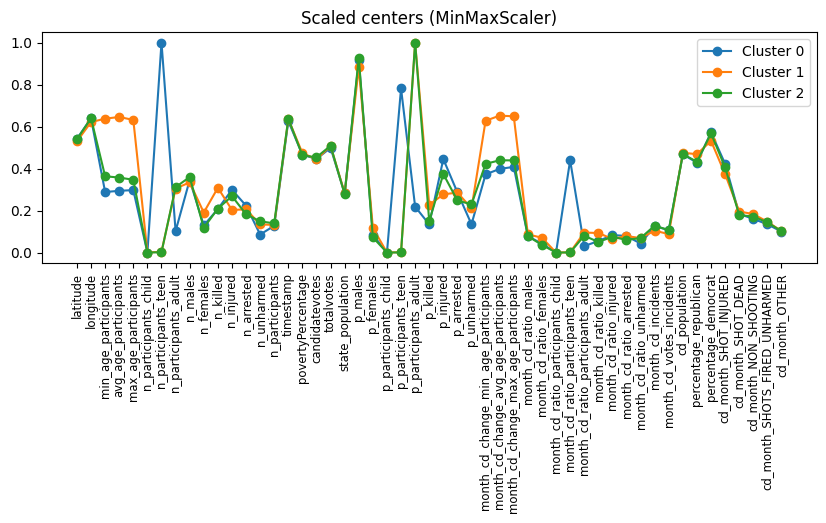

In [102]:
centers_s = best_model.cluster_centers_
cols = df.columns

#mean = np.mean(df.values, axis=0)
#std_dev = np.std(df.values, axis=0)
#centers = [c*std_dev + mean for c in centers_s]

centers = scaler.inverse_transform(centers_s)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df)
centers_s2 = minmaxscaler.transform(centers)

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Not scaled centers')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Scaled centers (StandardScaler)')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s2[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.title('Scaled centers (MinMaxScaler)')
plt.legend()
plt.show()

In [103]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          7672        5215
1         27731       25846
2         74111       50402

In [104]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.595329    0.404671
1  0.517592    0.482408
2  0.595207    0.404793

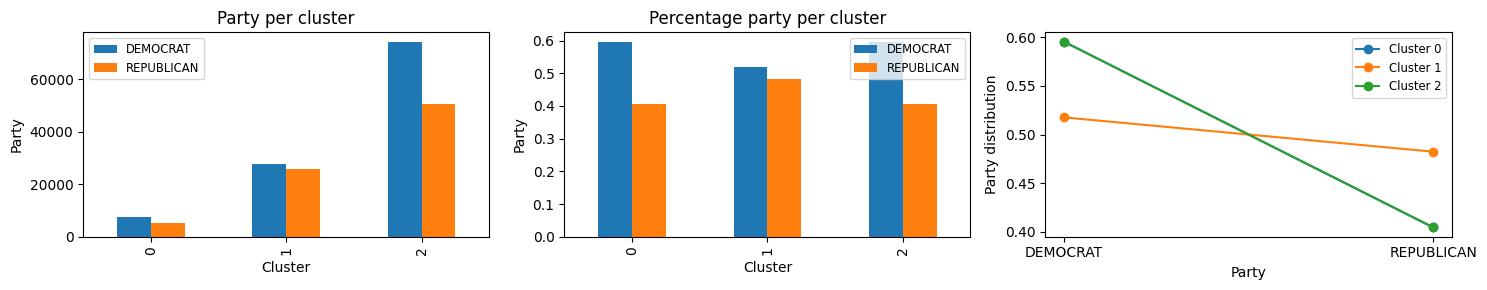

In [105]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [106]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          473   414   394   394   446   438   406   417   442   388  ...   
1         2009  1703  1788  1793  1740  1799  1696  1700  1665  1723  ...   
2         4478  3913  3951  4029  4165  3992  4069  4072  3960  3901  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          384   425   408   427   415   418   425   402   382   224  
1         1710  1739  1661  1775  1812  1777  1732  1705  1651  1080  
2         3987  4072  3987  4273  4126  4192  4166  3836  3773  2512  

[3 rows x 31 columns]

In [107]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036704  0.032125  0.030573  0.030573  0.034609  0.033988  0.031505   
1  0.037497  0.031786  0.033373  0.033466  0.032477  0.033578  0.031655   
2  0.035964  0.031426  0.031732  0.032358  0.033450  0.032061  0.032679   

         8         9         10  ...        22        23        24        25  \
0  0.032358  0.034298  0.030108  ...  0.029797  0.032979  0.031660  0.033134   
1  0.031730  0.031077  0.032159  ...  0.031917  0.032458  0.031002  0.033130   
2  0.032703  0.031804  0.031330  ...  0.032021  0.032703  0.032021  0.034318   

         26        27        28        29        30        31  
0  0.032203  0.032436  0.032979  0.031194  0.029642  0.017382  
1  0.033820  0.033167  0.032327  0.031823  0.030815  0.020158  
2  0.033137  0.033667  0.033458  0.030808  0.030302  0.020175  

[3 rows x 31 columns]

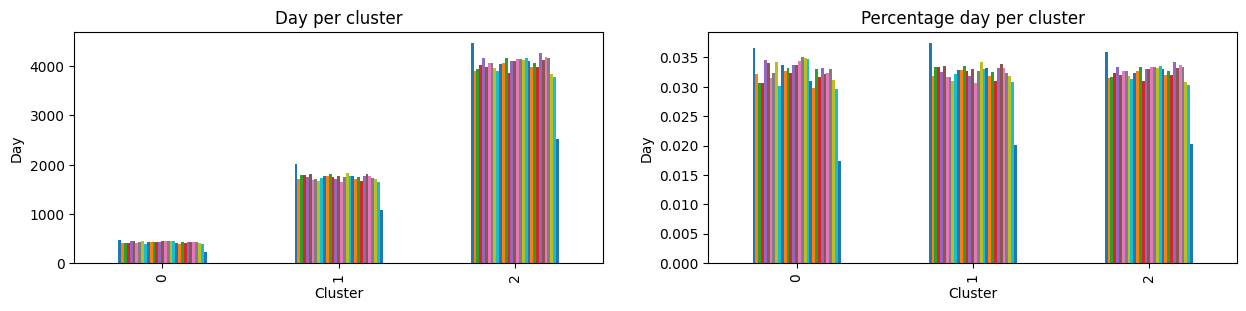

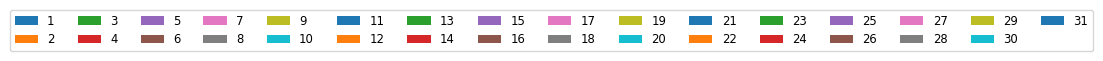

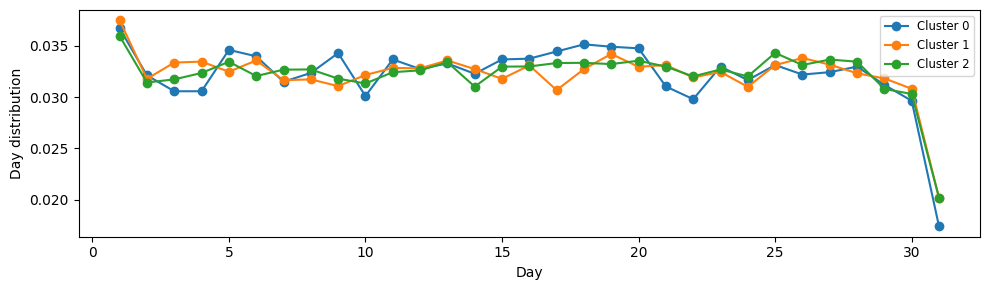

In [108]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [109]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c['date_month'])
month_xt_pct

date_month     1     2      3     4      5     6      7      8      9      10  \
row_0                                                                           
0            1253  1079   1205  1000   1093   966   1089   1098   1022   1059   
1            5305  4443   5118  4030   4215  4129   4576   4541   4268   4494   
2           11952  9721  11952  9510  10292  9469  10786  11040  10118  10265   

date_month    11     12  
row_0                    
0           1014   1009  
1           3961   4497  
2           9398  10010

In [110]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097230  0.083728  0.093505  0.077598  0.084814  0.074959  0.084504   
1  0.099016  0.082927  0.095526  0.075219  0.078672  0.077067  0.085410   
2  0.095990  0.078072  0.095990  0.076378  0.082658  0.076048  0.086625   

         8         9         10        11        12  
0  0.085202  0.079305  0.082176  0.078684  0.078296  
1  0.084757  0.079661  0.083879  0.073931  0.083935  
2  0.088665  0.081261  0.082441  0.075478  0.080393

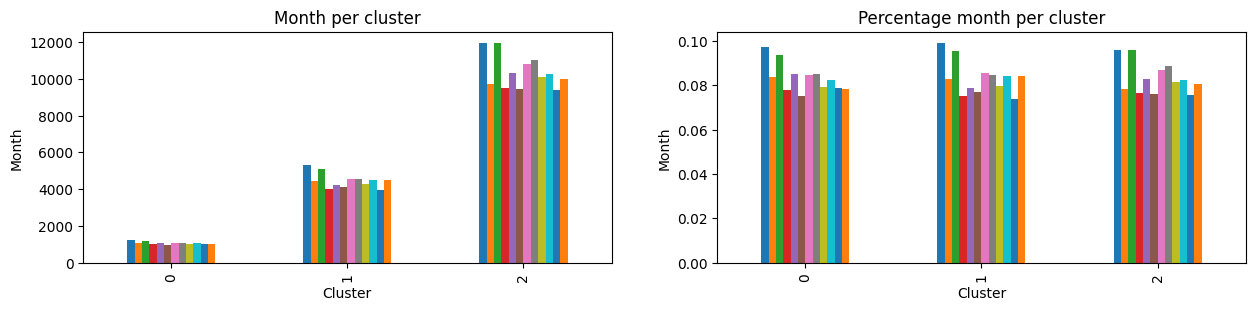

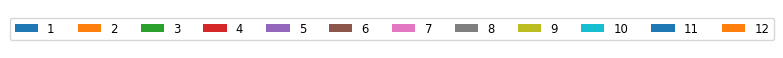

In [111]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [112]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               2    2358    2802    3302    3603     820
1              15    8851   11335   14515   15399    3462
2              24   20583   25285   34874   35930    7817

In [113]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000155  0.182975  0.217428  0.256227  0.279584  0.063630
1  0.000280  0.165201  0.211565  0.270918  0.287418  0.064617
2  0.000193  0.165308  0.203071  0.280083  0.288564  0.062781

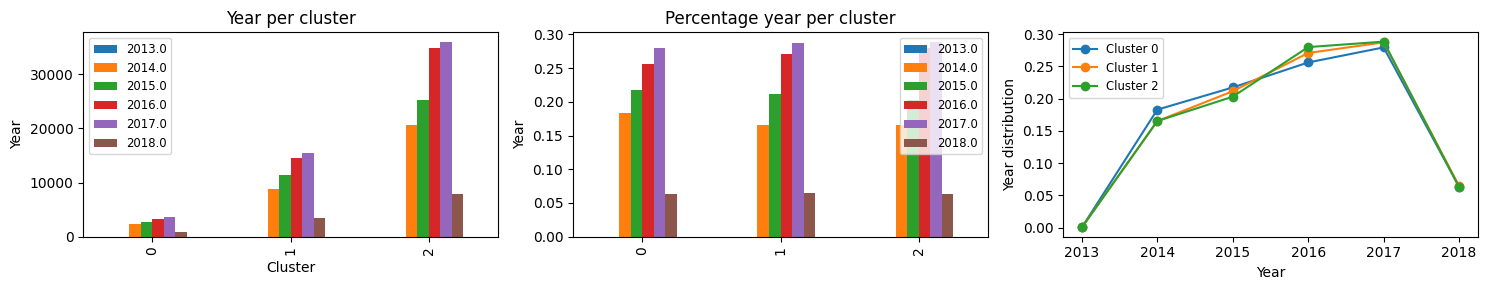

In [114]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [115]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          251       5      109       170         625       166          138   
1         1313      38      639       761        3220       871          746   
2         2773     114     1162      1481        6445      1828         1891   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           130      787      503  ...            32        478    610    63   
1           309     3293     2099  ...           161       1688   3016   257   
2           996     7149     4654  ...           297       3982   5904   532   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           11       406         190             51        296       20  
1          122      1281         917            454       1101      158  
2          252      3163        1716            820       2796      273  

[3 rows x 50 columns]

In [116]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.019477  0.000388  0.008458  0.013192    0.048498  0.012881     0.010708   
1  0.024507  0.000709  0.011927  0.014204    0.060100  0.016257     0.013924   
2  0.022271  0.000916  0.009332  0.011894    0.051762  0.014681     0.015187   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.010088  0.061069  0.039032  ...      0.002483   0.037092  0.047335   
1  0.005767  0.061463  0.039177  ...      0.003005   0.031506  0.056293   
2  0.007999  0.057416  0.037378  ...      0.002385   0.031981  0.047417   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004889  0.000854  0.031505    0.014744       0.003957   0.022969   
1  0.004797  0.002277  0.023910    0.017116       0.008474   0.020550   
2  0.004273  0.002024  0.025403    0.013782       0.006586   0.022455   

    WYOMING  
0  0.001552  
1  0.002949  
2  0.002193  

[3 rows x 50 columns]

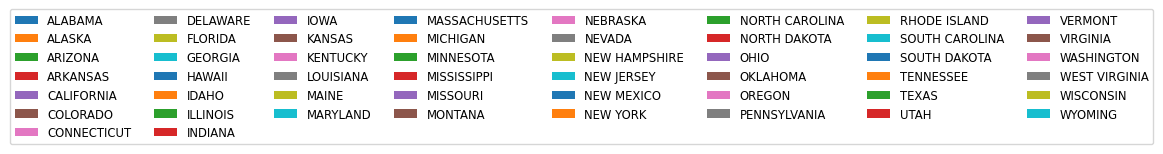

In [117]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [118]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    165                   19   
1                                   1485                   93   
2                                   4221                  227   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  2   
1                                                 2                  6   
2                                                 2                 13   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   16                             0   
1                                   80                             4   
2                                  162                            24   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                  7         5   
1                                     10                 90        14   
2                                     24                 95        43   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        23  ...                   9   
1                                       228  ...                  81   
2                                       594  ...                 149   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          48        1   
1                                     0               0         166       12   
2                                     4               3         446       17   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        2         127                0   
1                                       33         550                2   
2                                       36        1321                3   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      66                       0  
1                                     267                       0  
2                                     802                       1  

[3 rows x 49 columns]

In [119]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.012804             0.001474                  0.000000   
1       0.027717             0.001736                  0.000037   
2       0.033900             0.001823                  0.000016   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000155     0.001242                      0.000000   
1           0.000112     0.001493                      0.000075   
2           0.000104     0.001301                      0.000193   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000155           0.000543  0.000388          0.001785  ...   
1       0.000187           0.001680  0.000261          0.004256  ...   
2       0.000193           0.000763  0.000345          0.004771  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.000698      0.000000        0.000000    0.003725  0.000078   
1            0.001512      0.000000        0.000000    0.003098  0.000224   
2            0.001197      0.000032        0.000024    0.003582  0.000137   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000155    0.009855         0.000000        0.005121   
1         0.000616    0.010266         0.000037        0.004983   
2         0.000289    0.010609         0.000024        0.006441   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000000  
2                0.000008  

[3 rows x 49 columns]

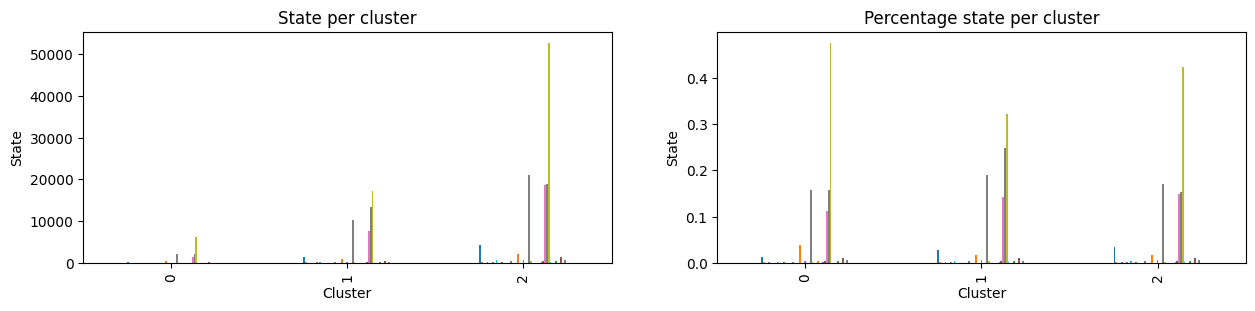

In [120]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced augmented data clustering

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


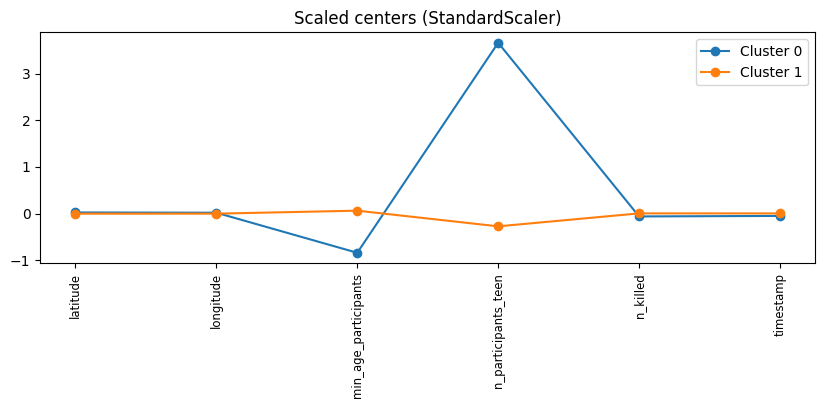

In [121]:
centers_s = best_model_r.cluster_centers_
cols = reduced.columns

mean = np.mean(df[cols].values, axis=0)
std_dev = np.std(df[cols].values, axis=0)
centers = [c*std_dev + mean for c in centers_s]

#centers = scaler_orig.inverse_transform(centers_s)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df[cols])
centers_s2 = minmaxscaler.transform(centers)

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Not scaled centers')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Scaled centers (StandardScaler)')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s2[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.title('Scaled centers (MinMaxScaler)')
plt.legend()
plt.show()

In [122]:
party_xt_pct = pd.crosstab(best_model_r.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          7929        5334
1        101585       76129

In [123]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.597829    0.402171
1  0.571621    0.428379

In [124]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [125]:
day_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          488   425   403   409   457   452   421   428   451   406  ...   
1         6472  5605  5730  5807  5894  5777  5750  5761  5616  5606  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          398   433   424   434   425   426   434   416   400   239  
1         5683  5803  5632  6041  5928  5961  5889  5527  5406  3577  

[2 rows x 31 columns]

In [126]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   
1  0.036418  0.031539  0.032243  0.032676  0.033166  0.032507  0.032355   

         8         9         10  ...        22        23        24        25  \
0  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   
1  0.032417  0.031601  0.031545  ...  0.031978  0.032654  0.031691  0.033993   

         26        27        28        29        30        31  
0  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  
1  0.033357  0.033543  0.033138  0.031101  0.030420  0.020128  

[2 rows x 31 columns]

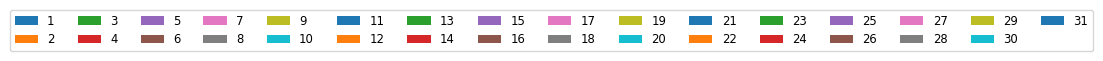

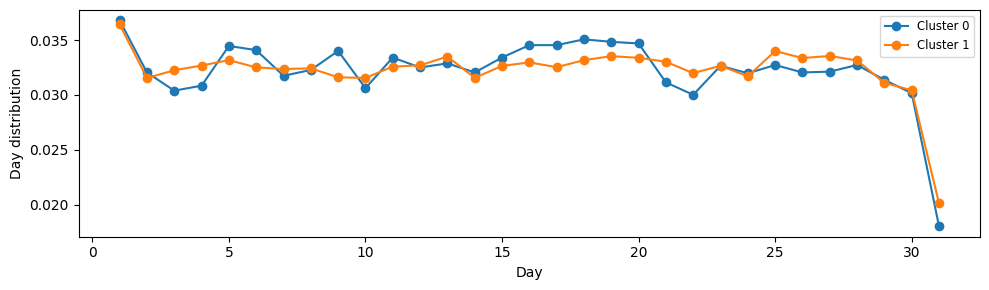

In [127]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [128]:
month_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0            1287   1101   1249   1026   1113   1000   1127   1134   1058   
1           17223  14142  17026  13514  14487  13564  15324  15545  14350   

date_month     10     11     12  
row_0                            
0            1092   1039   1037  
1           14726  13334  14479

In [129]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   
1  0.096914  0.079577  0.095806  0.076044  0.081519  0.076325  0.086228   

         8         9         10        11        12  
0  0.085501  0.079771  0.082334  0.078338  0.078187  
1  0.087472  0.080748  0.082863  0.075031  0.081474

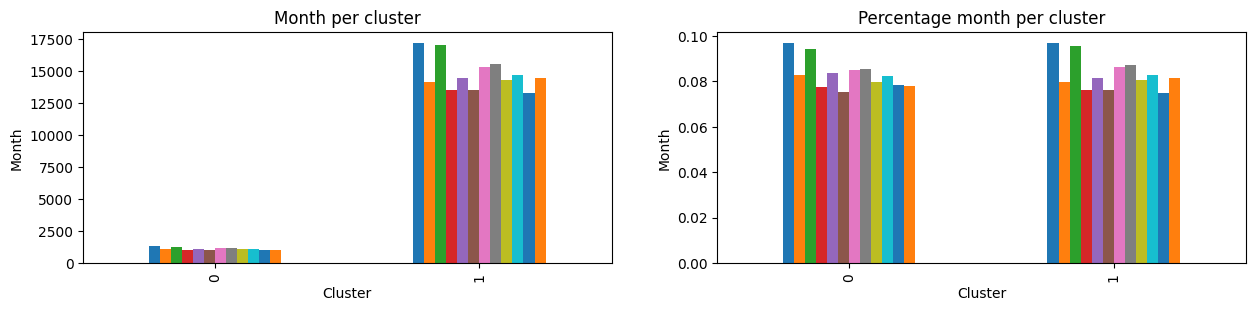

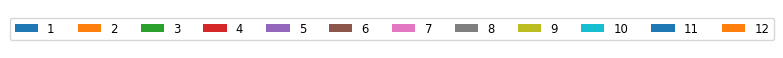

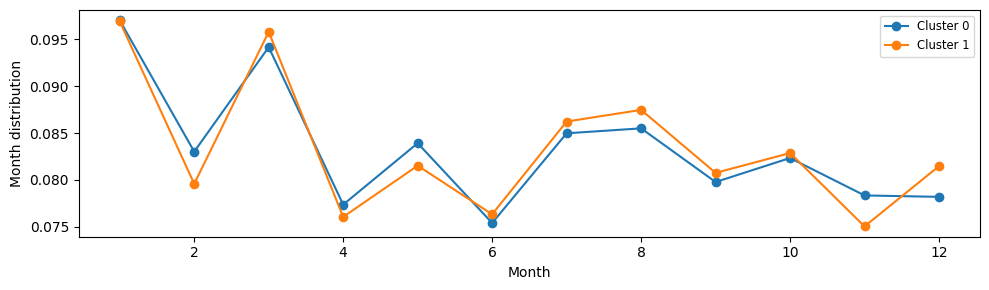

In [130]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [131]:
year_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               2    2450    2869    3408    3697     837
1              39   29342   36553   49283   51235   11262

In [132]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108
1  0.000219  0.165108  0.205684  0.277316  0.288300  0.063371

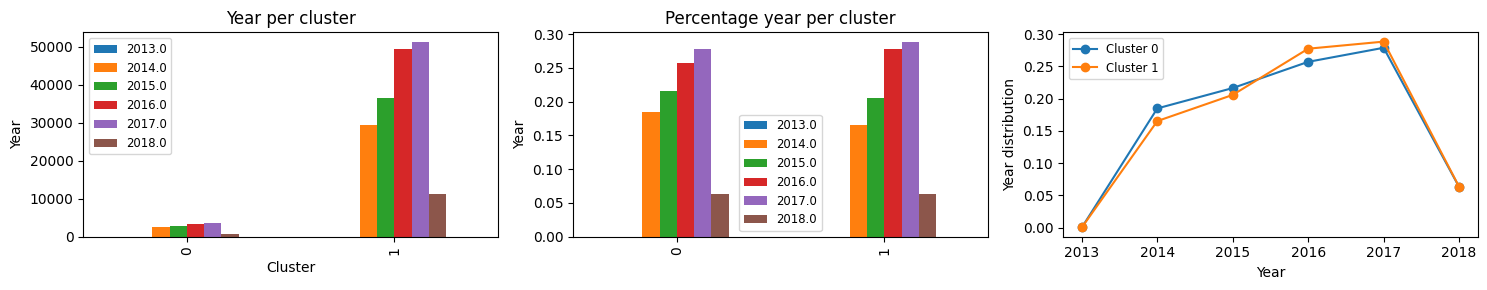

In [133]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [134]:
state_xt_pct = pd.crosstab(best_model_r.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          256       5      114       173         641       173          146   
1         4081     152     1796      2239        9649      2692         2629   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           133      820      514  ...            33        497    621    63   
1          1302    10409     6742  ...           457       5651   8909   789   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           11       414         194             53        307       20  
1          374      4436        2629           1272       3886      431  

[2 rows x 50 columns]

In [135]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   
1  0.022964  0.000855  0.010106  0.012599    0.054295  0.015148     0.014793   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   
1  0.007326  0.058572  0.037937  ...      0.002572   0.031798  0.050131   

      UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN   WYOMING  
0  0.00475  0.000829  0.031215    0.014627       0.003996   0.023147  0.001508  
1  0.00444  0.002105  0.024961    0.014793       0.007158   0.021867  0.002425  

[2 rows x 50 columns]

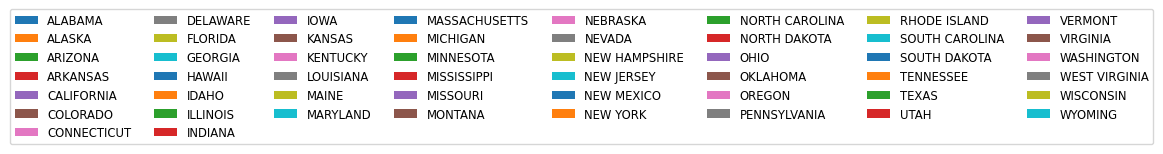

In [136]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [137]:
ic_xt_pct = pd.crosstab(best_model_r.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    174                   20   
1                                   5697                  319   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  2   
1                                                 4                 19   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   18                             0   
1                                  240                            28   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                  8         5   
1                                     34                184        57   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        25  ...                   9   
1                                       820  ...                 230   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          49        1   
1                                     4               3         611       29   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        3         132                0   
1                                       68        1866                5   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      68                       0  
1                                    1067                       1  

[2 rows x 49 columns]

In [138]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.013119             0.001508                  0.000000   
1       0.032057             0.001795                  0.000023   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000151     0.001357                      0.000000   
1           0.000107     0.001350                      0.000158   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000151           0.000603  0.000377          0.001885  ...   
1       0.000191           0.001035  0.000321          0.004614  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.000679      0.000000        0.000000    0.003694  0.000075   
1            0.001294      0.000023        0.000017    0.003438  0.000163   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000226    0.009952         0.000000        0.005127   
1         0.000383    0.010500         0.000028        0.006004   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000006  

[2 rows x 49 columns]

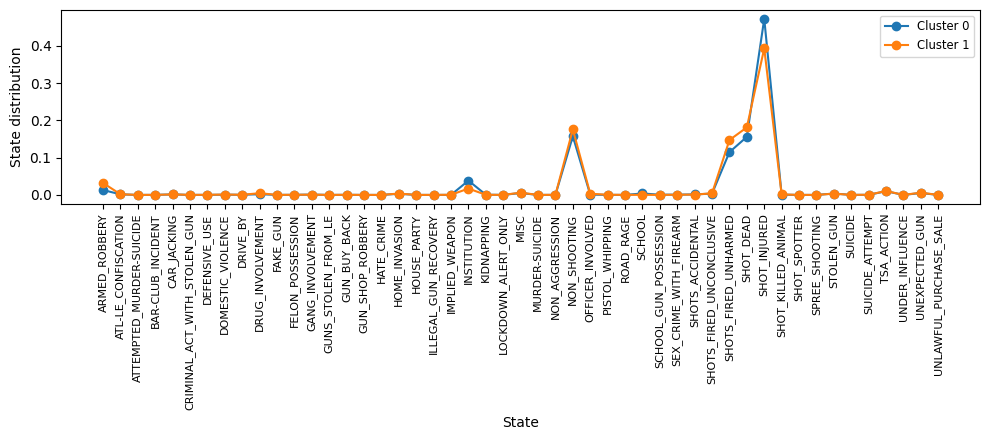

In [139]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators clustering

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


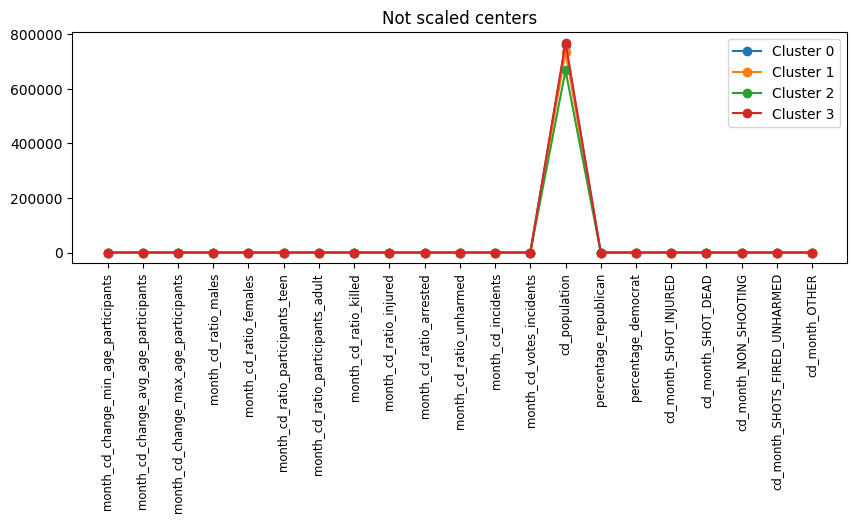

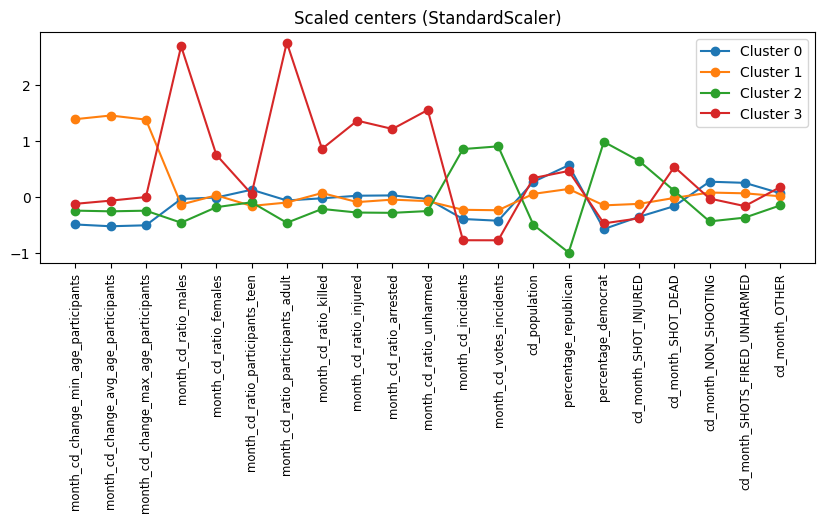

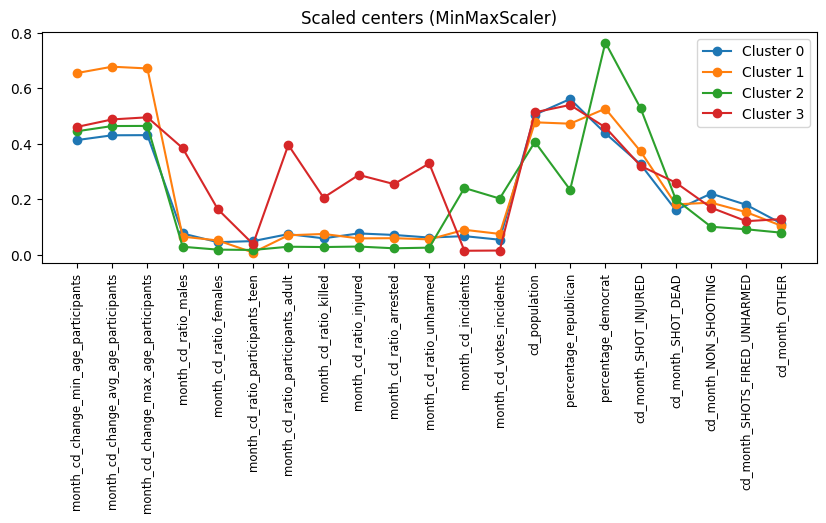

In [140]:
centers_s = best_model_ind.cluster_centers_
cols = df_ind.columns

#mean = np.mean(df_ind[cols].values, axis=0)
#std_dev = np.std(df_ind[cols].values, axis=0)
#centers = [c*std_dev + mean for c in centers_s]

centers = scaler_ind.inverse_transform(centers_s)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df_ind[cols])
centers_s2 = minmaxscaler.transform(centers)

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Not scaled centers')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Scaled centers (StandardScaler)')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s2[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.title('Scaled centers (MinMaxScaler)')
plt.legend()
plt.show()

In [141]:
party_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         26498       54116
1         20607       18757
2         57720         584
3          4689        8006

In [142]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.328702    0.671298
1  0.523499    0.476501
2  0.989984    0.010016
3  0.369358    0.630642

In [143]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [144]:
day_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         2990  2525  2554  2581  2678  2644  2606  2657  2555  2503  ...   
1         1473  1228  1319  1333  1305  1320  1256  1245  1209  1273  ...   
2         2046  1860  1822  1897  1963  1866  1897  1871  1857  1852  ...   
3          451   417   438   405   405   399   412   416   446   384  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         2611  2617  2461  2773  2711  2746  2712  2486  2376  1590  
1         1232  1270  1236  1280  1327  1320  1288  1214  1225   800  
2         1789  1929  1960  2009  1896  1913  1893  1845  1824  1161  
3          449   420   399   413   419   408   430   398   381   265  

[4 rows x 31 columns]

In [145]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.037090  0.031322  0.031682  0.032017  0.033220  0.032798  0.032327   
1  0.037420  0.031196  0.033508  0.033863  0.033152  0.033533  0.031907   
2  0.035092  0.031902  0.031250  0.032536  0.033668  0.032005  0.032536   
3  0.035526  0.032848  0.034502  0.031902  0.031902  0.031430  0.032454   

         8         9         10  ...        22        23        24        25  \
0  0.032960  0.031694  0.031049  ...  0.032389  0.032463  0.030528  0.034398   
1  0.031628  0.030713  0.032339  ...  0.031298  0.032263  0.031399  0.032517   
2  0.032090  0.031850  0.031765  ...  0.030684  0.033085  0.033617  0.034457   
3  0.032769  0.035132  0.030248  ...  0.035368  0.033084  0.031430  0.032532   

         26        27        28        29        30        31  
0  0.033629  0.034064  0.033642  0.030838  0.029474  0.019724  
1  0.033711  0.033533  0.032720  0.030840  0.031120  0.020323  
2  0.032519  0.032811  0.032468  0.031644  0.031284  0.019913  
3  0.033005  0.032139  0.033872  0.031351  0.030012  0.020874  

[4 rows x 31 columns]

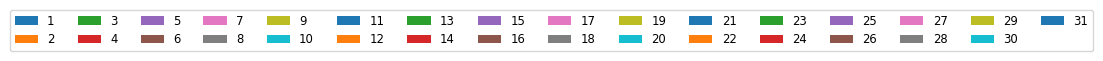

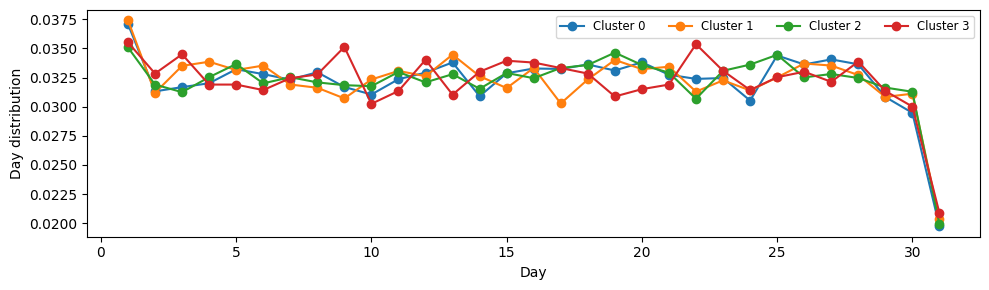

In [146]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [147]:
month_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_month'])
month_xt_pct

date_month    1     2     3     4     5     6     7     8     9     10    11  \
row_0                                                                          
0           8155  6669  7999  6126  6469  6038  6807  6782  6416  6503  6151   
1           3995  3266  3781  2969  3145  2965  3394  3336  3069  3287  2922   
2           5109  3895  5280  4440  5003  4581  5350  5631  4909  5059  4252   
3           1251  1413  1215  1005   983   980   900   930  1014   969  1048   

date_month    12  
row_0             
0           6499  
1           3235  
2           4795  
3            987

In [148]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.101161  0.082728  0.099226  0.075992  0.080247  0.074900  0.084439   
1  0.101489  0.082969  0.096052  0.075424  0.079895  0.075323  0.086221   
2  0.087627  0.066805  0.090560  0.076153  0.085809  0.078571  0.091760   
3  0.098543  0.111304  0.095707  0.079165  0.077432  0.077196  0.070894   

         8         9         10        11        12  
0  0.084129  0.079589  0.080668  0.076302  0.080619  
1  0.084747  0.077965  0.083503  0.074230  0.082182  
2  0.096580  0.084197  0.086769  0.072928  0.082241  
3  0.073257  0.079874  0.076329  0.082552  0.077747

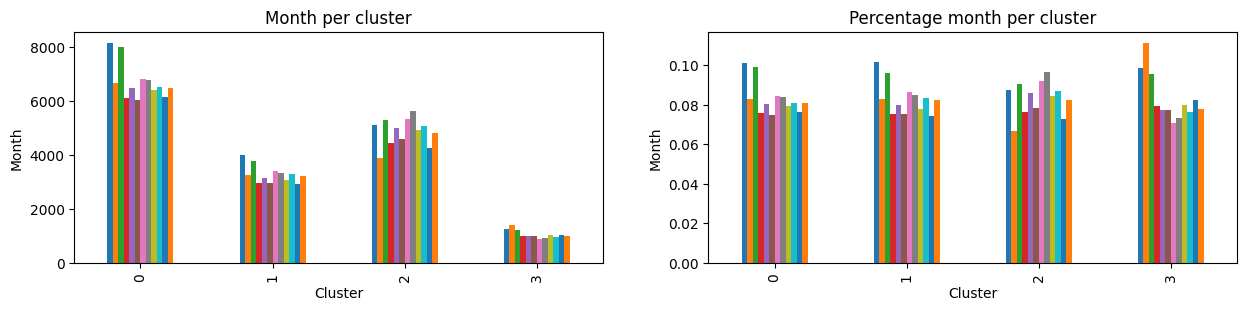

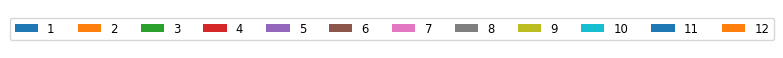

In [149]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [150]:
year_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               1   12522   17046   22332   23662    5051
1               7    6316    8009   10916   11546    2570
2               5    9538   11146   16763   17064    3788
3              28    3416    3221    2680    2660     690

In [151]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000012  0.155333  0.211452  0.277024  0.293522  0.062657
1  0.000178  0.160451  0.203460  0.277309  0.293314  0.065288
2  0.000086  0.163591  0.191170  0.287510  0.292673  0.064970
3  0.002206  0.269082  0.253722  0.211107  0.209531  0.054352

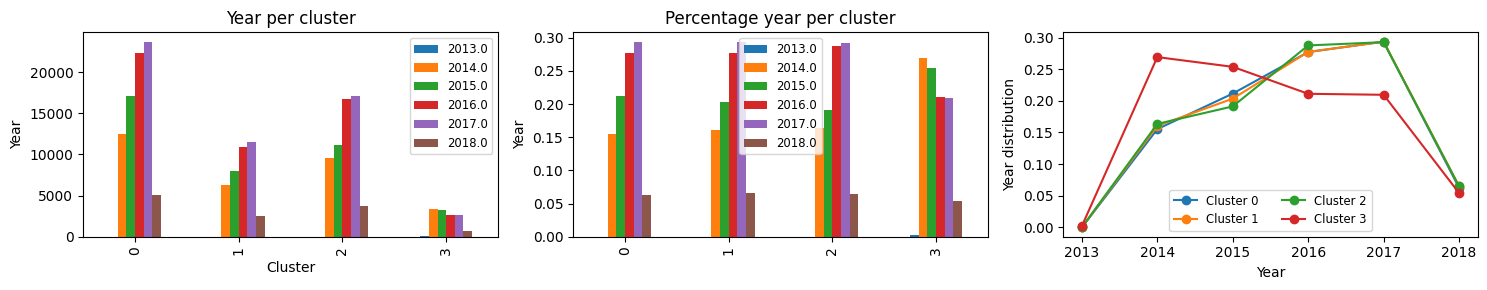

In [152]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small', ncols=2)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [153]:
state_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         1896     121      382      1696        4180      1851         1855   
1          835      36      308       642        2344       700          748   
2         1442       0      728         0        2373        74           62   
3          164       0      492        74        1393       240          110   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           990     5647     3131  ...           355       2346   3951   508   
1           365     2454     1577  ...           115       1223   1879   181   
2            80     2353     2167  ...             0       2386   2403     0   
3             0      775      381  ...            20        193   1297   163   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          239      1592        1521            893       1066      318  
1          111       852         715            348        678      101  
2            7      2000         213              0       2146        0  
3           28       406         374             84        303       32  

[4 rows x 50 columns]

In [154]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.023519  0.001501  0.004739  0.021039    0.051852  0.022961     0.023011   
1  0.021212  0.000915  0.007824  0.016309    0.059547  0.017783     0.019002   
2  0.024732  0.000000  0.012486  0.000000    0.040700  0.001269     0.001063   
3  0.012918  0.000000  0.038755  0.005829    0.109728  0.018905     0.008665   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.012281  0.070050  0.038839  ...      0.004404   0.029102  0.049011   
1  0.009272  0.062341  0.040062  ...      0.002921   0.031069  0.047734   
2  0.001372  0.040357  0.037167  ...      0.000000   0.040923  0.041215   
3  0.000000  0.061048  0.030012  ...      0.001575   0.015203  0.102166   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.006302  0.002965  0.019748    0.018868       0.011077   0.013224   
1  0.004598  0.002820  0.021644    0.018164       0.008841   0.017224   
2  0.000000  0.000120  0.034303    0.003653       0.000000   0.036807   
3  0.012840  0.002206  0.031981    0.029460       0.006617   0.023868   

    WYOMING  
0  0.003945  
1  0.002566  
2  0.000000  
3  0.002521  

[4 rows x 50 columns]

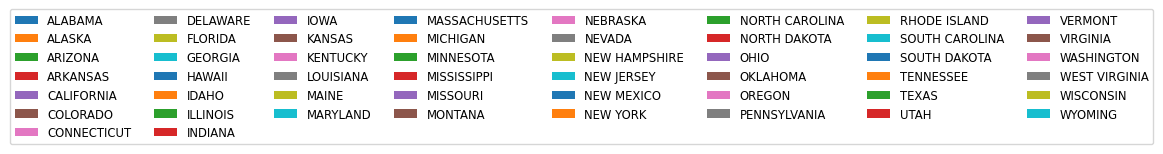

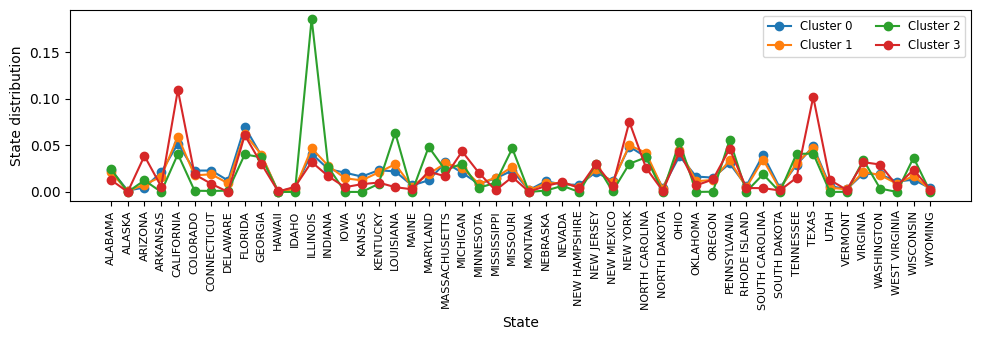

In [155]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [156]:
ic_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   2833                  180   
1                                   1208                   75   
2                                   1377                   58   
3                                    453                   26   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 1                 11   
1                                                 2                  6   
2                                                 1                  1   
3                                                 0                  3   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   79                            21   
1                                   47                             1   
2                                  106                             6   
3                                   26                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     12                 82        31   
1                                      9                 65         9   
2                                     10                 26        18   
3                                      5                 19         4   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       442  ...                 117   
1                                       177  ...                  56   
2                                       159  ...                  26   
3                                        67  ...                  40   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     1               1         416       16   
1                                     0               0         115        9   
2                                     3               1          76        4   
3                                     0               1          53        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       24         823                2   
1                                       25         433                2   
2                                       10         558                0   
3                                       12         184                1   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                     544                       0  
1                                     199                       1  
2                                     317                       0  
3                                      75                       0  

[4 rows x 49 columns]

In [157]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.035143             0.002233                  0.000012   
1       0.030688             0.001905                  0.000051   
2       0.023618             0.000995                  0.000017   
3       0.035683             0.002048                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000136     0.000980                      0.000261   
1           0.000152     0.001194                      0.000025   
2           0.000017     0.001818                      0.000103   
3           0.000236     0.002048                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000149           0.001017  0.000385          0.005483  ...   
1       0.000229           0.001651  0.000229          0.004496  ...   
2       0.000172           0.000446  0.000309          0.002727  ...   
3       0.000394           0.001497  0.000315          0.005278  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001451      0.000012        0.000012    0.005160  0.000198   
1            0.001423      0.000000        0.000000    0.002921  0.000229   
2            0.000446      0.000051        0.000017    0.001304  0.000069   
3            0.003151      0.000000        0.000079    0.004175  0.000079   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000298    0.010209         0.000025        0.006748   
1         0.000635    0.011000         0.000051        0.005055   
2         0.000172    0.009571         0.000000        0.005437   
3         0.000945    0.014494         0.000079        0.005908   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000025  
2                0.000000  
3                0.000000  

[4 rows x 49 columns]

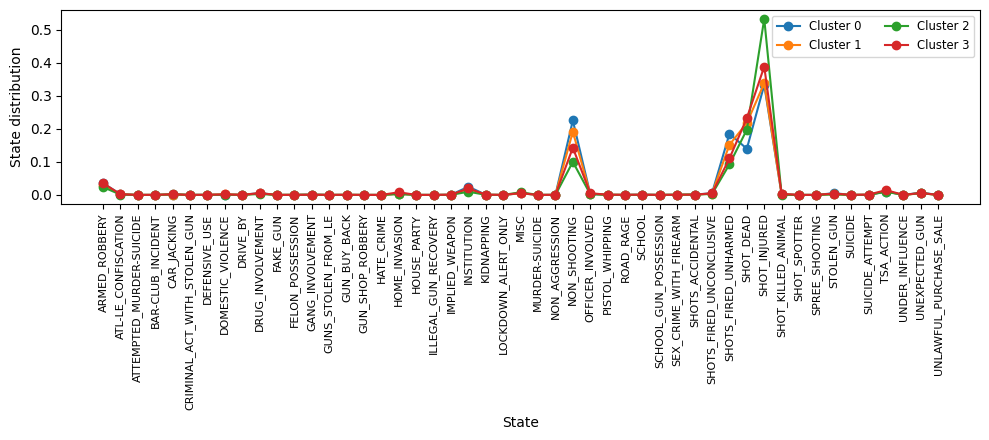

In [158]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators reduced clustering

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


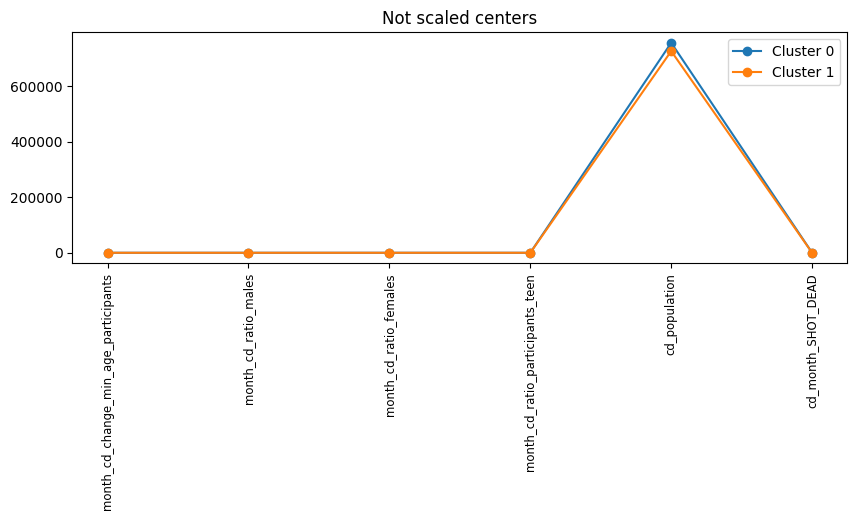

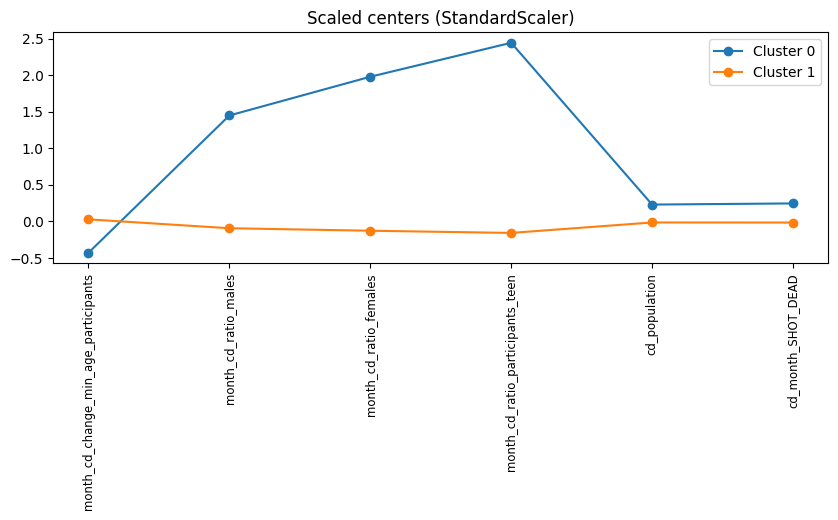

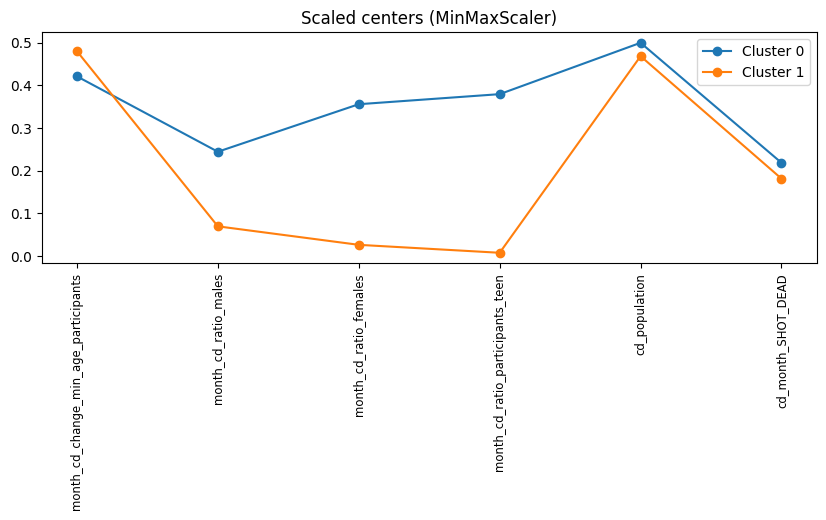

In [172]:
centers_s = best_model_r_ind.cluster_centers_
cols = reduced_ind.columns

mean = np.mean(df_ind[cols].values, axis=0)
std_dev = np.std(df_ind[cols].values, axis=0)
centers = [c*std_dev + mean for c in centers_s]

#centers = scaler_orig.inverse_transform(centers_s)

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df_ind[cols])
centers_s2 = minmaxscaler.transform(centers)

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Not scaled centers')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.legend()
plt.title('Scaled centers (StandardScaler)')


plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers_s2[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, fontsize='small', rotation=90)
plt.title('Scaled centers (MinMaxScaler)')
plt.legend()
plt.show()

In [173]:
party_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          4558        7002
1        104956       74461

In [174]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.394291    0.605709
1  0.584984    0.415016

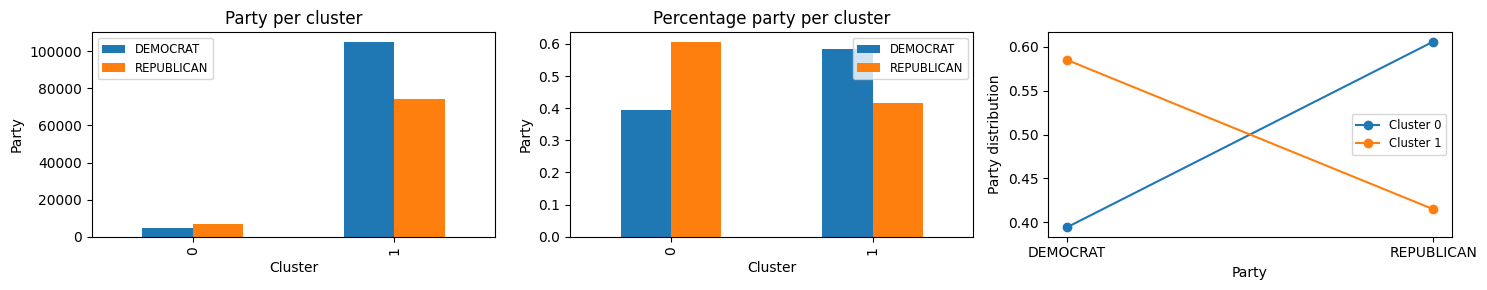

In [175]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [176]:
day_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          417   396   359   364   390   399   368   353   384   343  ...   
1         6543  5634  5774  5852  5961  5830  5803  5836  5683  5669  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          401   384   336   396   394   387   399   358   337   222  
1         5680  5852  5720  6079  5959  6000  5924  5585  5469  3594  

[2 rows x 31 columns]

In [177]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036073  0.034256  0.031055  0.031488  0.033737  0.034516  0.031834   
1  0.036468  0.031402  0.032182  0.032617  0.033224  0.032494  0.032344   

         8         9         10  ...        22        23        24        25  \
0  0.030536  0.033218  0.029671  ...  0.034689  0.033218  0.029066  0.034256   
1  0.032528  0.031675  0.031597  ...  0.031658  0.032617  0.031881  0.033882   

         26        27        28        29        30        31  
0  0.034083  0.033478  0.034516  0.030969  0.029152  0.019204  
1  0.033213  0.033442  0.033018  0.031129  0.030482  0.020032  

[2 rows x 31 columns]

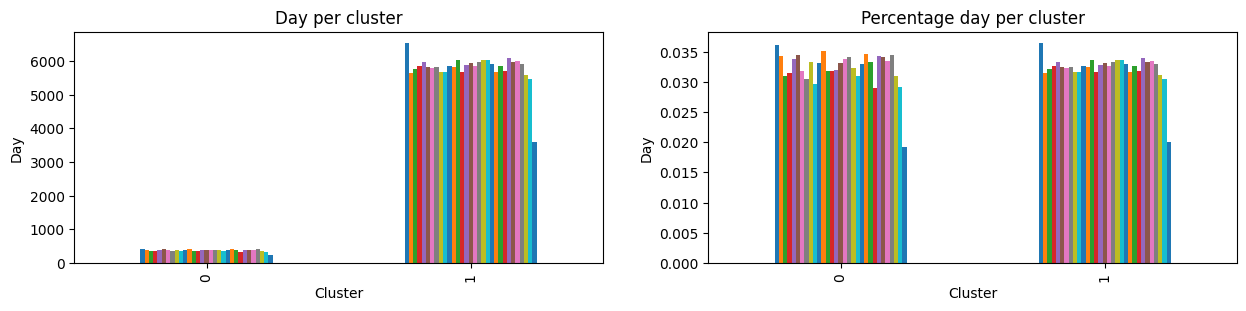

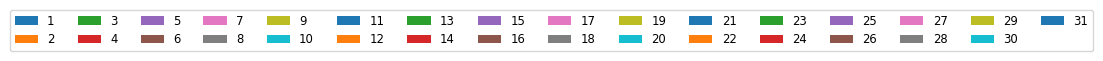

In [178]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [179]:
month_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0            1133   1219   1119    897    943    884    844    871    860   
1           17377  14024  17156  13643  14657  13680  15607  15808  14548   

date_month     10     11     12  
row_0                            
0             930    950    910  
1           14888  13423  14606

In [180]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.098010  0.105450  0.096799  0.077595  0.081574  0.076471  0.073010   
1  0.096853  0.078164  0.095621  0.076041  0.081692  0.076247  0.086987   

         8         9        10        11        12  
0  0.075346  0.074394  0.08045  0.082180  0.078720  
1  0.088108  0.081085  0.08298  0.074815  0.081408

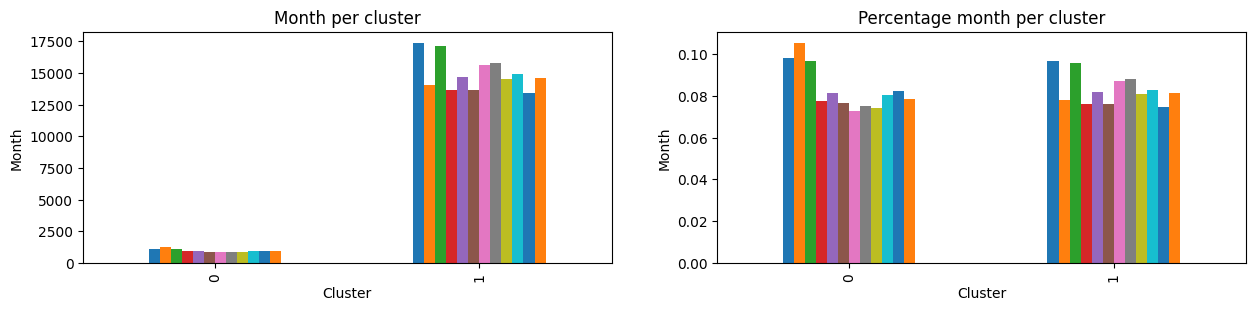

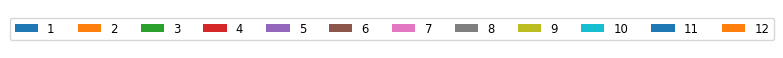

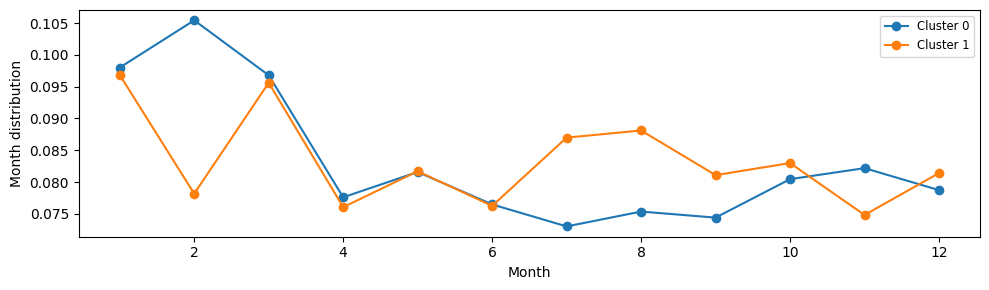

In [181]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [182]:
year_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              18    2645    2755    2697    2755     690
1              23   29147   36667   49994   52177   11409

In [183]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.001557  0.228806  0.238322  0.233304  0.238322  0.059689
1  0.000128  0.162454  0.204367  0.278647  0.290814  0.063589

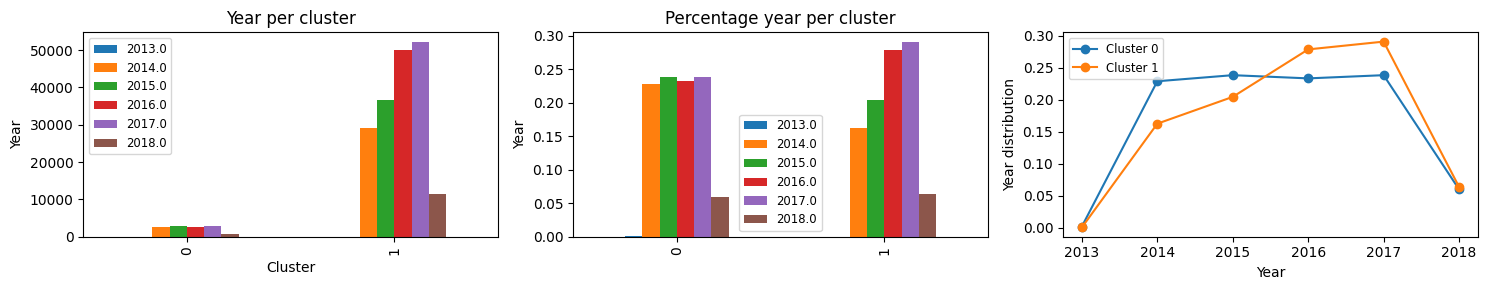

In [184]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [185]:
state_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          202       0      298       120        1023       214          128   
1         4135     157     1612      2292        9267      2651         2647   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0            23      720      386  ...            29        252    967   111   
1          1412    10509     6870  ...           461       5896   8563   741   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           26       315         289            101        238       28  
1          359      4535        2534           1224       3955      423  

[2 rows x 50 columns]

In [186]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.017474  0.000000  0.025779  0.010381    0.088495  0.018512     0.011073   
1  0.023047  0.000875  0.008985  0.012775    0.051651  0.014776     0.014753   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0   0.00199  0.062284  0.033391  ...      0.002509   0.021799  0.083651   
1   0.00787  0.058573  0.038291  ...      0.002569   0.032862  0.047727   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.009602  0.002249  0.027249    0.025000       0.008737   0.020588   
1  0.004130  0.002001  0.025276    0.014124       0.006822   0.022044   

    WYOMING  
0  0.002422  
1  0.002358  

[2 rows x 50 columns]

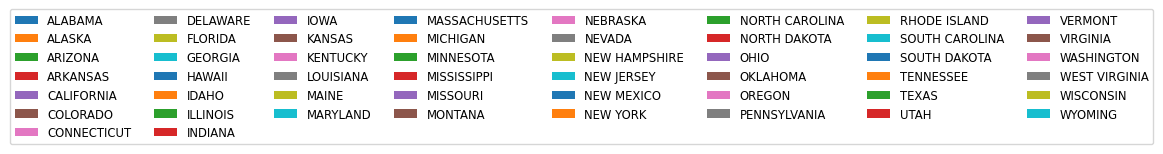

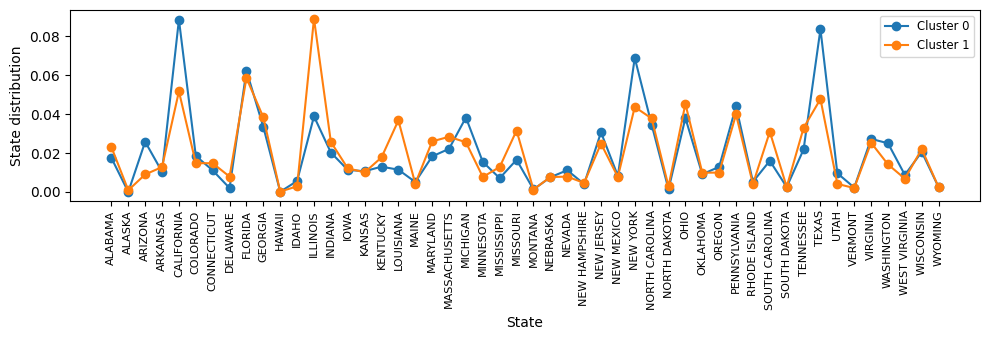

In [187]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [188]:
ic_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    258                   18   
1                                   5613                  321   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  1   
1                                                 4                 20   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   29                             0   
1                                  229                            28   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                 31         3   
1                                     34                161        59   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        52  ...                  25   
1                                       793  ...                 214   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               1          53        0   
1                                     4               2         607       30   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       10         140                0   
1                                       61        1858                5   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      54                       0  
1                                    1081                       1  

[2 rows x 49 columns]

In [189]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.022318             0.001557                  0.000000   
1       0.031285             0.001789                  0.000022   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000087     0.002509                      0.000000   
1           0.000111     0.001276                      0.000156   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000173           0.002682  0.000260          0.004498  ...   
1       0.000190           0.000897  0.000329          0.004420  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.002163      0.000000        0.000087    0.004585  0.000000   
1            0.001193      0.000022        0.000011    0.003383  0.000167   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000865    0.012111         0.000000        0.004671   
1         0.000340    0.010356         0.000028        0.006025   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000006  

[2 rows x 49 columns]

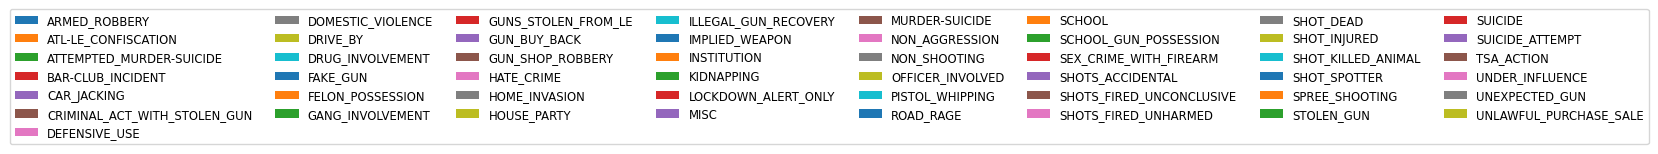

In [190]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()